## Importing Useful Libraries

In [551]:
# Libraries for Data Analysis
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Libraries for different Models 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, Dense, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
# Libraries for Evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

# Library for Encoding
from sklearn.preprocessing import OrdinalEncoder

# Making color Pallette
pal = sns.color_palette()
pal_list = list(pal)

# Libraries to study images
import torch
import datetime as dt
import os
import tqdm

# Preliminary Analysis

## a. Importing Datasets

In [10]:
items = pd.read_csv('items.csv') # inported items dataset
restaurants = pd.read_csv('resturants.csv') # restuarant dataset
sales = pd.read_csv('sales.csv') # sales dataset

## b. Eximining Datasets

In [13]:
# checking for column values and thier types
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109600 entries, 0 to 109599
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   date        109600 non-null  object 
 1   item_id     109600 non-null  int64  
 2   price       109600 non-null  float64
 3   item_count  109600 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 3.3+ MB


In [15]:
# converting date column to data time format as it is an object type column
sales.date = pd.to_datetime(sales.date)

In [19]:
# checking inof of items data
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        100 non-null    int64  
 1   store_id  100 non-null    int64  
 2   name      100 non-null    object 
 3   kcal      100 non-null    int64  
 4   cost      100 non-null    float64
dtypes: float64(1), int64(3), object(1)
memory usage: 4.0+ KB


In [23]:
# checking info of restaurant data
restaurants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      6 non-null      int64 
 1   name    6 non-null      object
dtypes: int64(1), object(1)
memory usage: 228.0+ bytes


## c.  Merging the datasets into a single dataset which will have date, item id, price, item count, item names, kcal values, store id, and store name

In [27]:
# checking shapes of each dataset in order to merge them properly

print("sales data shape", sales.shape)
print("items data shape", items.shape)
print("restaurants data shape", restaurants.shape)

sales data shape (109600, 4)
items data shape (100, 5)
restaurants data shape (6, 2)


In [29]:
# checking counts for values in restaurant
restaurants.value_counts()

id  name          
1   Bob's Diner       1
2   Beachfront Bar    1
3   Sweet Shack       1
4   Fou Cher          1
5   Corner Cafe       1
6   Surfs Up          1
Name: count, dtype: int64

In [31]:
# Merged the sales and item data on the bases of item_id
merged_data = pd.merge(sales, items, left_on = "item_id", right_on = "id", how = "left")

In [33]:
# Finally, adding restaurant data into merged_data to make a single dataset with required features
data = pd.merge(merged_data, restaurants, left_on = 'store_id', right_on = 'id')

In [35]:
data.head()

,date,item_id,price,item_count,id_x,store_id,name_x,kcal,cost,id_y,name_y
0,2019-01-01,3,29.22,2.0,3,1,Sweet Fruity Cake,931,29.22,1,Bob's Diner
1,2019-01-01,4,26.42,22.0,4,1,Amazing Steak Dinner with Rolls,763,26.42,1,Bob's Diner
2,2019-01-01,12,4.87,7.0,12,1,Fantastic Sweet Cola,478,4.87,1,Bob's Diner
3,2019-01-01,13,4.18,12.0,13,1,Sweet Frozen Soft Drink,490,4.18,1,Bob's Diner
4,2019-01-01,16,3.21,136.0,16,1,Frozen Milky Smoothy,284,3.21,1,Bob's Diner


In [37]:
# as the id_x and id_y are somehow confusing and also they are not also duplicate, so we decided to drop them

data.drop(columns = ['id_x', 'id_y', 'cost'], inplace = True)

In [39]:
# now renaming the name_x and name_y column

data.rename(columns = {"name_x" : "item_name", "name_y": "restaurant_name"}, inplace = True)

# Exploratory Data Analysis

## a. Examining sales to understand pattern according to date

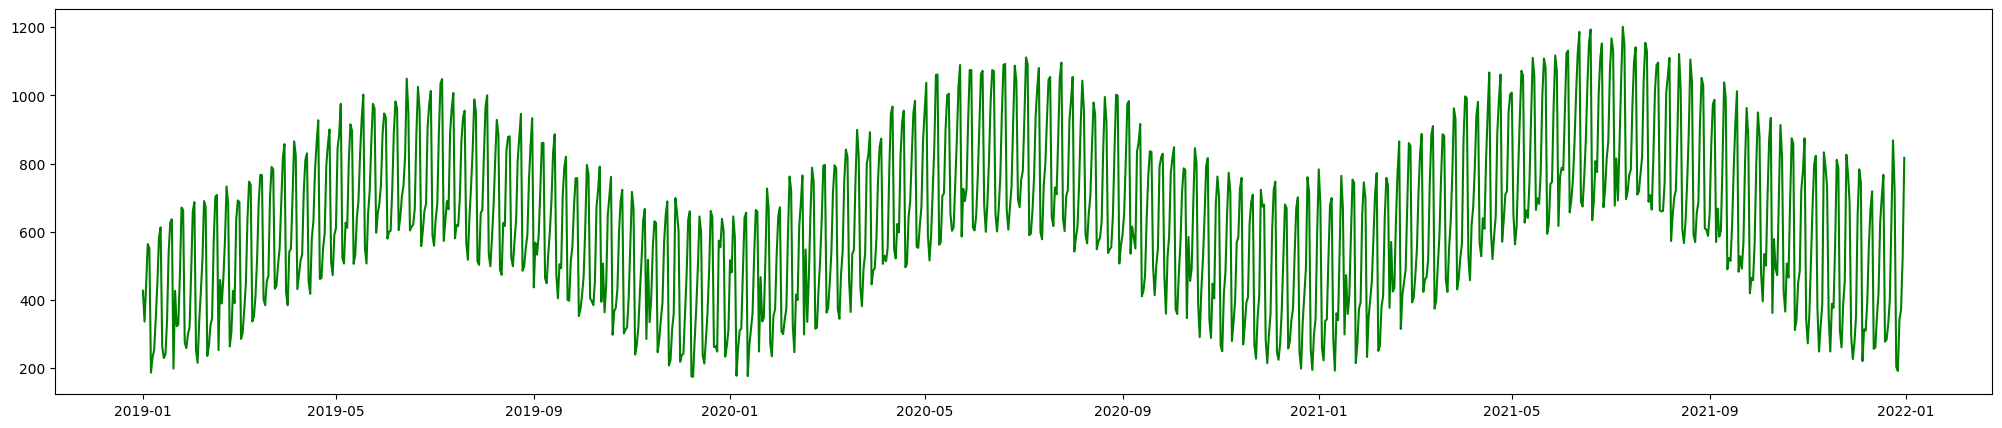

In [45]:
# displaying line graph to check for sales per date 

grpd = sales.groupby(['date'])[['item_count']].sum()
plt.figure(figsize = (25,5))
plt.plot(grpd, color = 'green')
plt.show()

## b. Looking out how sales fluctuate across different days

In [48]:
# creating weekdays column in order to check out sales per each day of the week 
data['weekday'] = data.date.dt.day_name()

In [50]:
data.head(2)

,date,item_id,price,item_count,store_id,item_name,kcal,restaurant_name,weekday
0,2019-01-01,3,29.22,2.0,1,Sweet Fruity Cake,931,Bob's Diner,Tuesday
1,2019-01-01,4,26.42,22.0,1,Amazing Steak Dinner with Rolls,763,Bob's Diner,Tuesday


In [52]:
# making a list of day's name for the sake of bar-graph

import calendar
day_names = list(calendar.day_name)

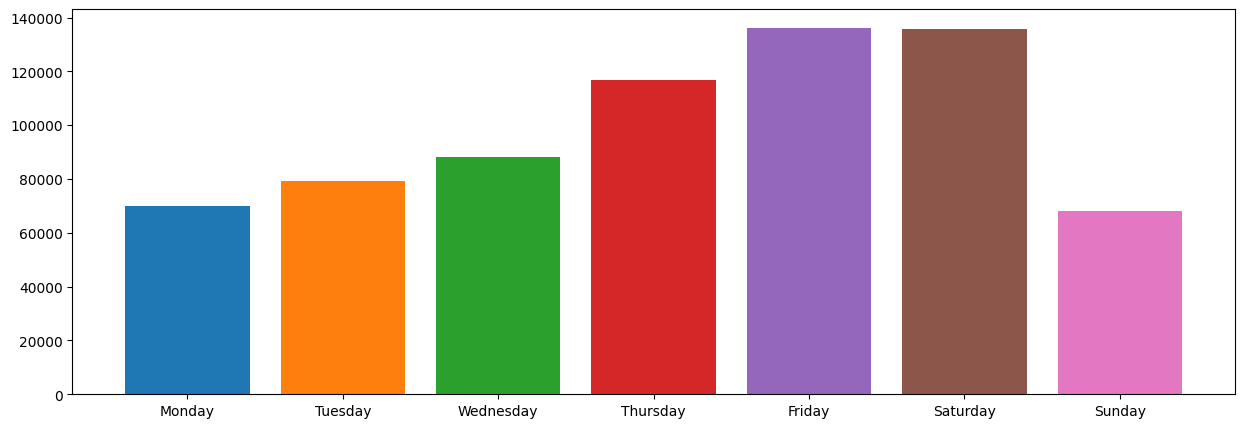

In [54]:
# displaying bar-graph to show the sales per days of week
grpd = data.groupby(['weekday'])[['item_count']].sum()
grpd = grpd.loc[day_names].squeeze()
plt.figure(figsize = (15,5))
plt.bar(height = grpd.values, x = grpd.index, color = pal)
plt.show()

## c. Looking for Trends per Month of the year

In [61]:
# creating month_name column in order to indentify the sales per month of the year

data['month_name'] = data.date.dt.month_name()

months = list(calendar.month_name)[1:]

In [63]:
data.head(2)

,date,item_id,price,item_count,store_id,item_name,kcal,restaurant_name,weekday,month_name
0,2019-01-01,3,29.22,2.0,1,Sweet Fruity Cake,931,Bob's Diner,Tuesday,January
1,2019-01-01,4,26.42,22.0,1,Amazing Steak Dinner with Rolls,763,Bob's Diner,Tuesday,January


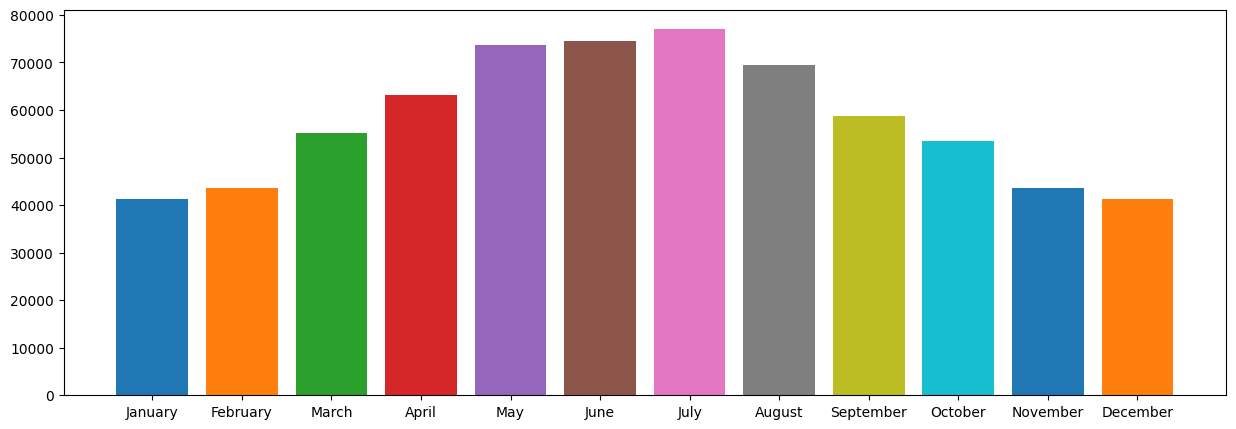

In [65]:
grpd = data[['month_name', 'item_count']].groupby('month_name').sum()
grpd = grpd.reindex(months)['item_count']
plt.figure(figsize=(15, 5))
plt.bar(grpd.index, grpd.values, color=pal)
plt.show()

## d. Analysing the sales distribution across different quaters of the years and notiable patterns

In [68]:
# creating year's quater column to check trends across the years
data['quarter'] = data.date.dt.quarter

data.tail(2)

,date,item_id,price,item_count,store_id,item_name,kcal,restaurant_name,weekday,month_name,quarter
109598,2021-12-31,99,5.32,0.0,4,Frozen Tomato Soft Drink,423,Fou Cher,Friday,December,4
109599,2021-12-31,100,2.48,0.0,2,Awesome Vodka Cocktail,223,Beachfront Bar,Friday,December,4


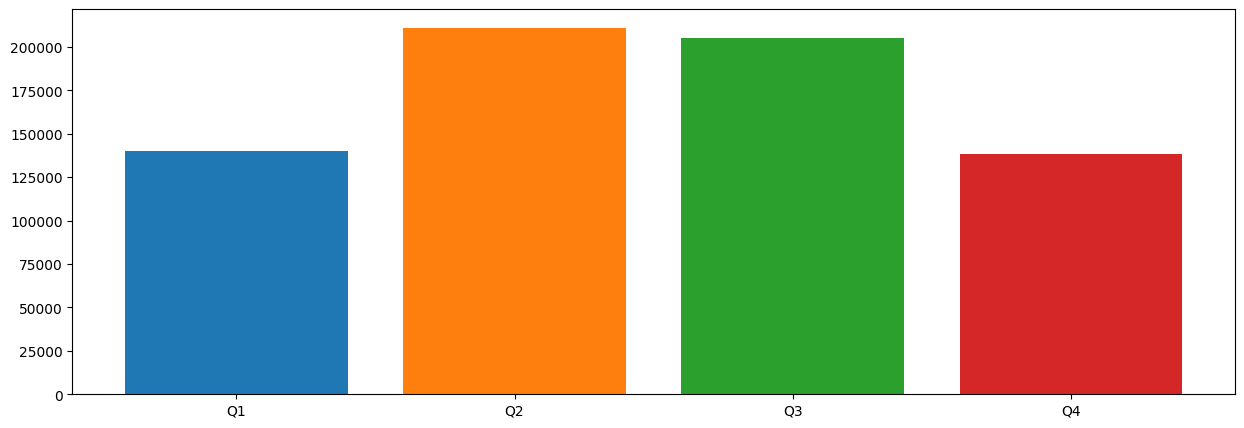

In [70]:
grpd = data.groupby(['quarter'])[['item_count']].sum().squeeze()
plt.figure(figsize = (15,5))
plt.bar(height = grpd.values, x = grpd.index, color = pal)
plt.xticks(range(1,5),["Q"+str(i) for i in range(1,5)])
plt.show()

In [74]:
# creating year column in order to recongnize sales for every year's quaters
data['year'] = data.date.dt.year
data['quart-year'] = "Q" + data.quarter.astype(str) + "-" + data.year.astype(str)

In [76]:
data.head(2)

,date,item_id,price,item_count,store_id,item_name,kcal,restaurant_name,weekday,month_name,quarter,year,quart-year
0,2019-01-01,3,29.22,2.0,1,Sweet Fruity Cake,931,Bob's Diner,Tuesday,January,1,2019,Q1-2019
1,2019-01-01,4,26.42,22.0,1,Amazing Steak Dinner with Rolls,763,Bob's Diner,Tuesday,January,1,2019,Q1-2019


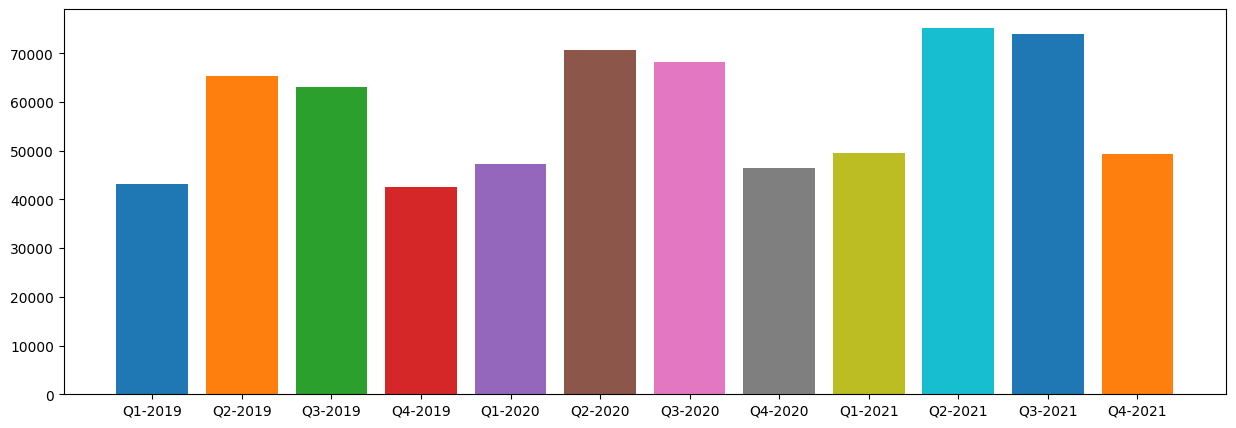

In [78]:
order = [f'Q{qtr}-{yr}' for yr in range(2019, 2022) for qtr in range(1, 5)]
grpd = data[['quart-year', 'item_count']].groupby('quart-year').sum()
grpd = grpd.reindex(order)['item_count']
plt.figure(figsize=(15, 5))
plt.bar(grpd.index, grpd.values, color=pal)
plt.show()

## e. Comparing the performance of Restaurants and finding our the restaurant with most sales and also looking for sales of each restaurant across different year, months, and days

In [81]:
# grouped out the data by restaurant_id and items sale's count and showing their sum 

data.groupby('store_id')[['item_count']].sum()

,item_count
store_id,
1,687527.0
2,1305.0
3,1736.0
4,1106.0
5,1310.0
6,1803.0


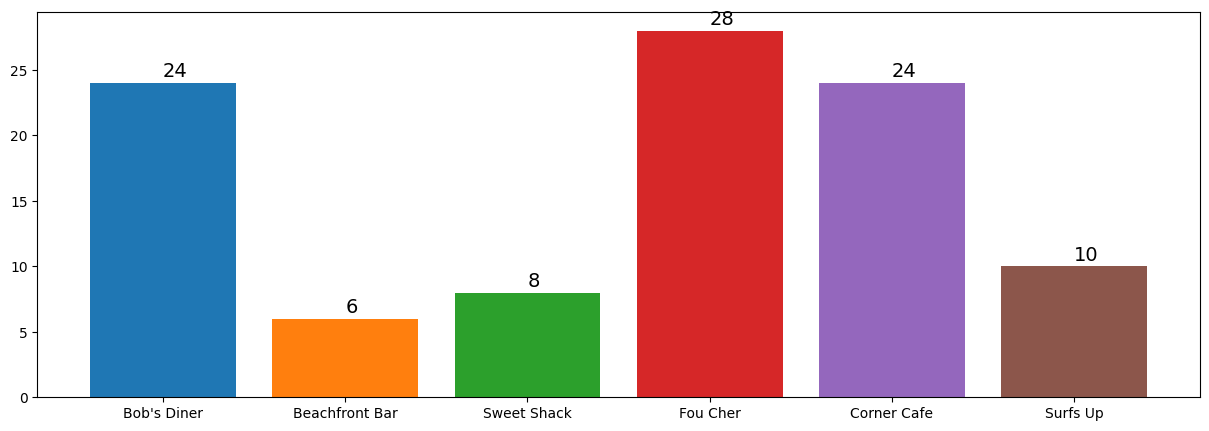

In [83]:
# plotting the graph to shows the sales of every restaurant to compare their performance

items_served = items.groupby('store_id')['id'].nunique()
plt.figure(figsize=(15, 5))
plt.bar(items_served.index, items_served, color=pal)
plt.xticks(ticks=range(1, 7), labels=restaurants.name)
for store_id in range(1, 7):
    plt.annotate(text=items_served[store_id], xy=(store_id, items_served[store_id] + 0.45), fontsize=14)

plt.show()

##### We can clearly see that the Fou Cher Restaurant have performed outrageously followed by Bob's Diner and Corner Cafe

### Store wise sales of each Restaurant

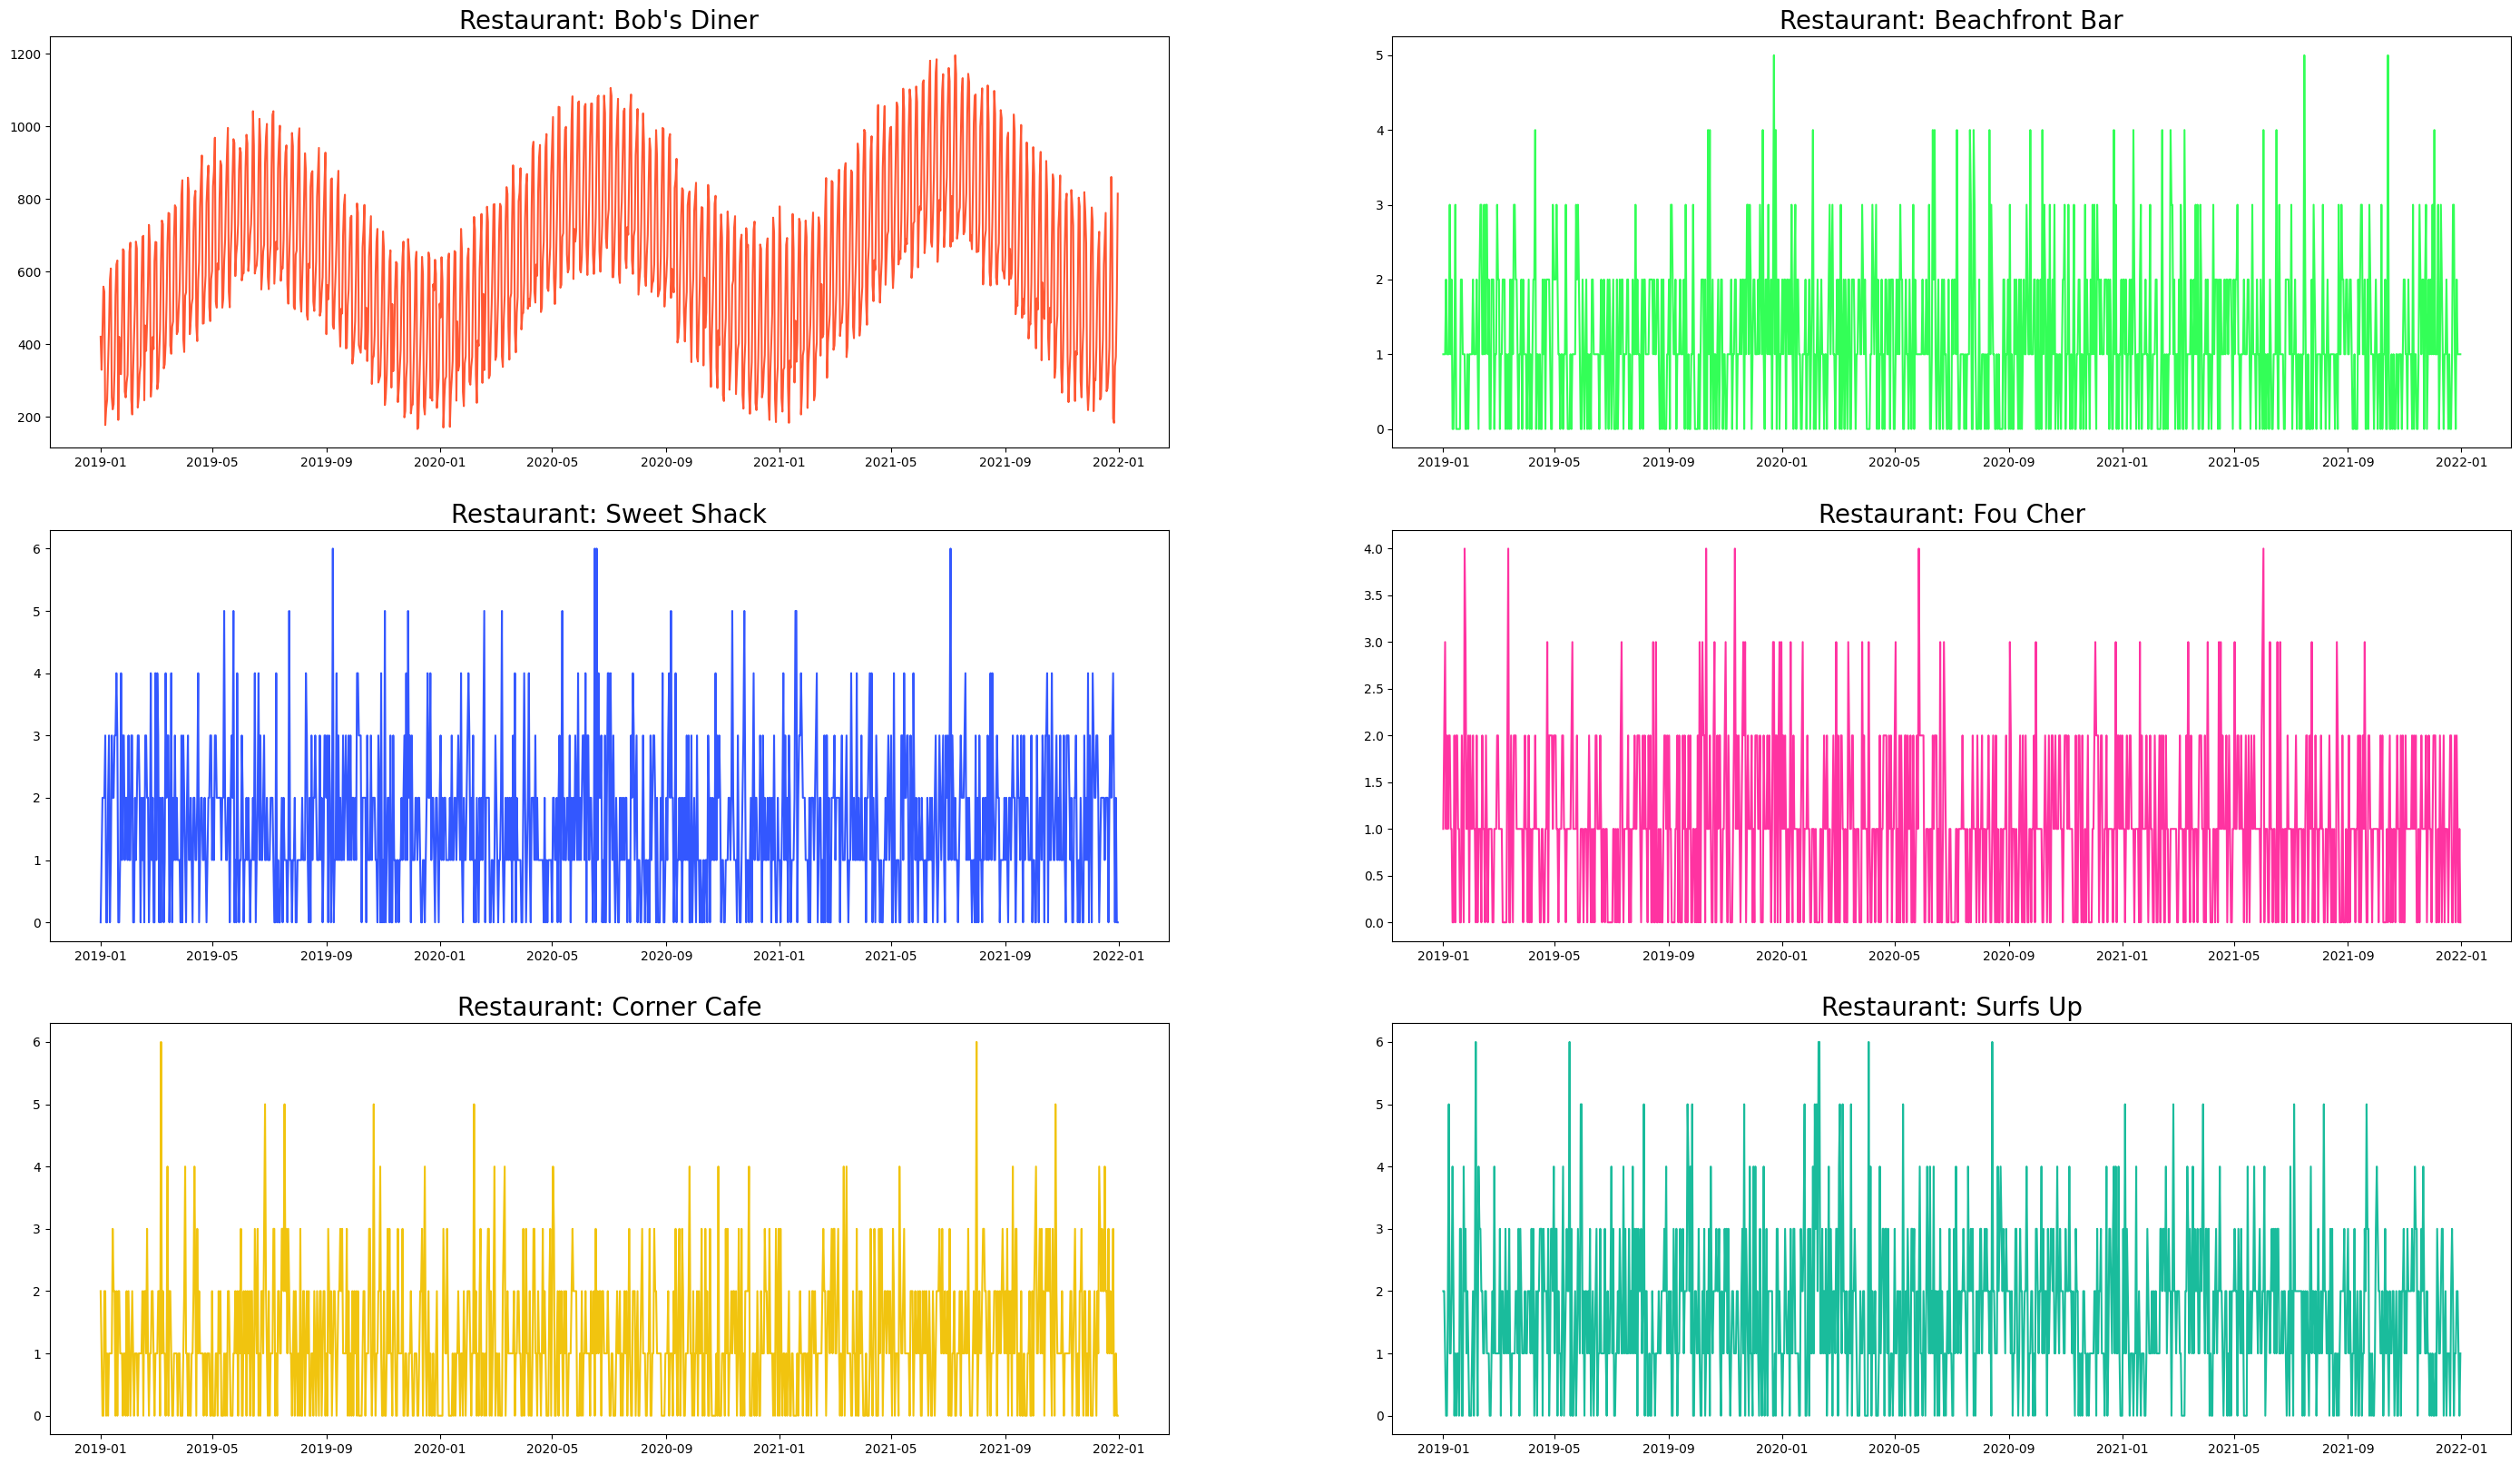

In [89]:
# making line plot of each restaurant showing their sales

plot_data = data.pivot_table(values='item_count', index='date', columns='store_id', aggfunc='sum')
fig, axes = plt.subplots(3, 2, figsize=(35, 20))

custom_colors = ['#FF5733', '#33FF57', '#3357FF', '#FF33A1', '#F1C40F', '#1ABC9C']

for idx, (store_id, ax) in enumerate(zip(range(1, 7), axes.flatten())):
    ax.plot(plot_data[store_id], color=custom_colors[idx])  
    restaurant_name = restaurants.loc[restaurants['id'] == store_id, 'name'].values[0]
    ax.set_title(f'Restaurant: {restaurant_name}', fontsize=20)

### Year wise Sales of each Restaurant

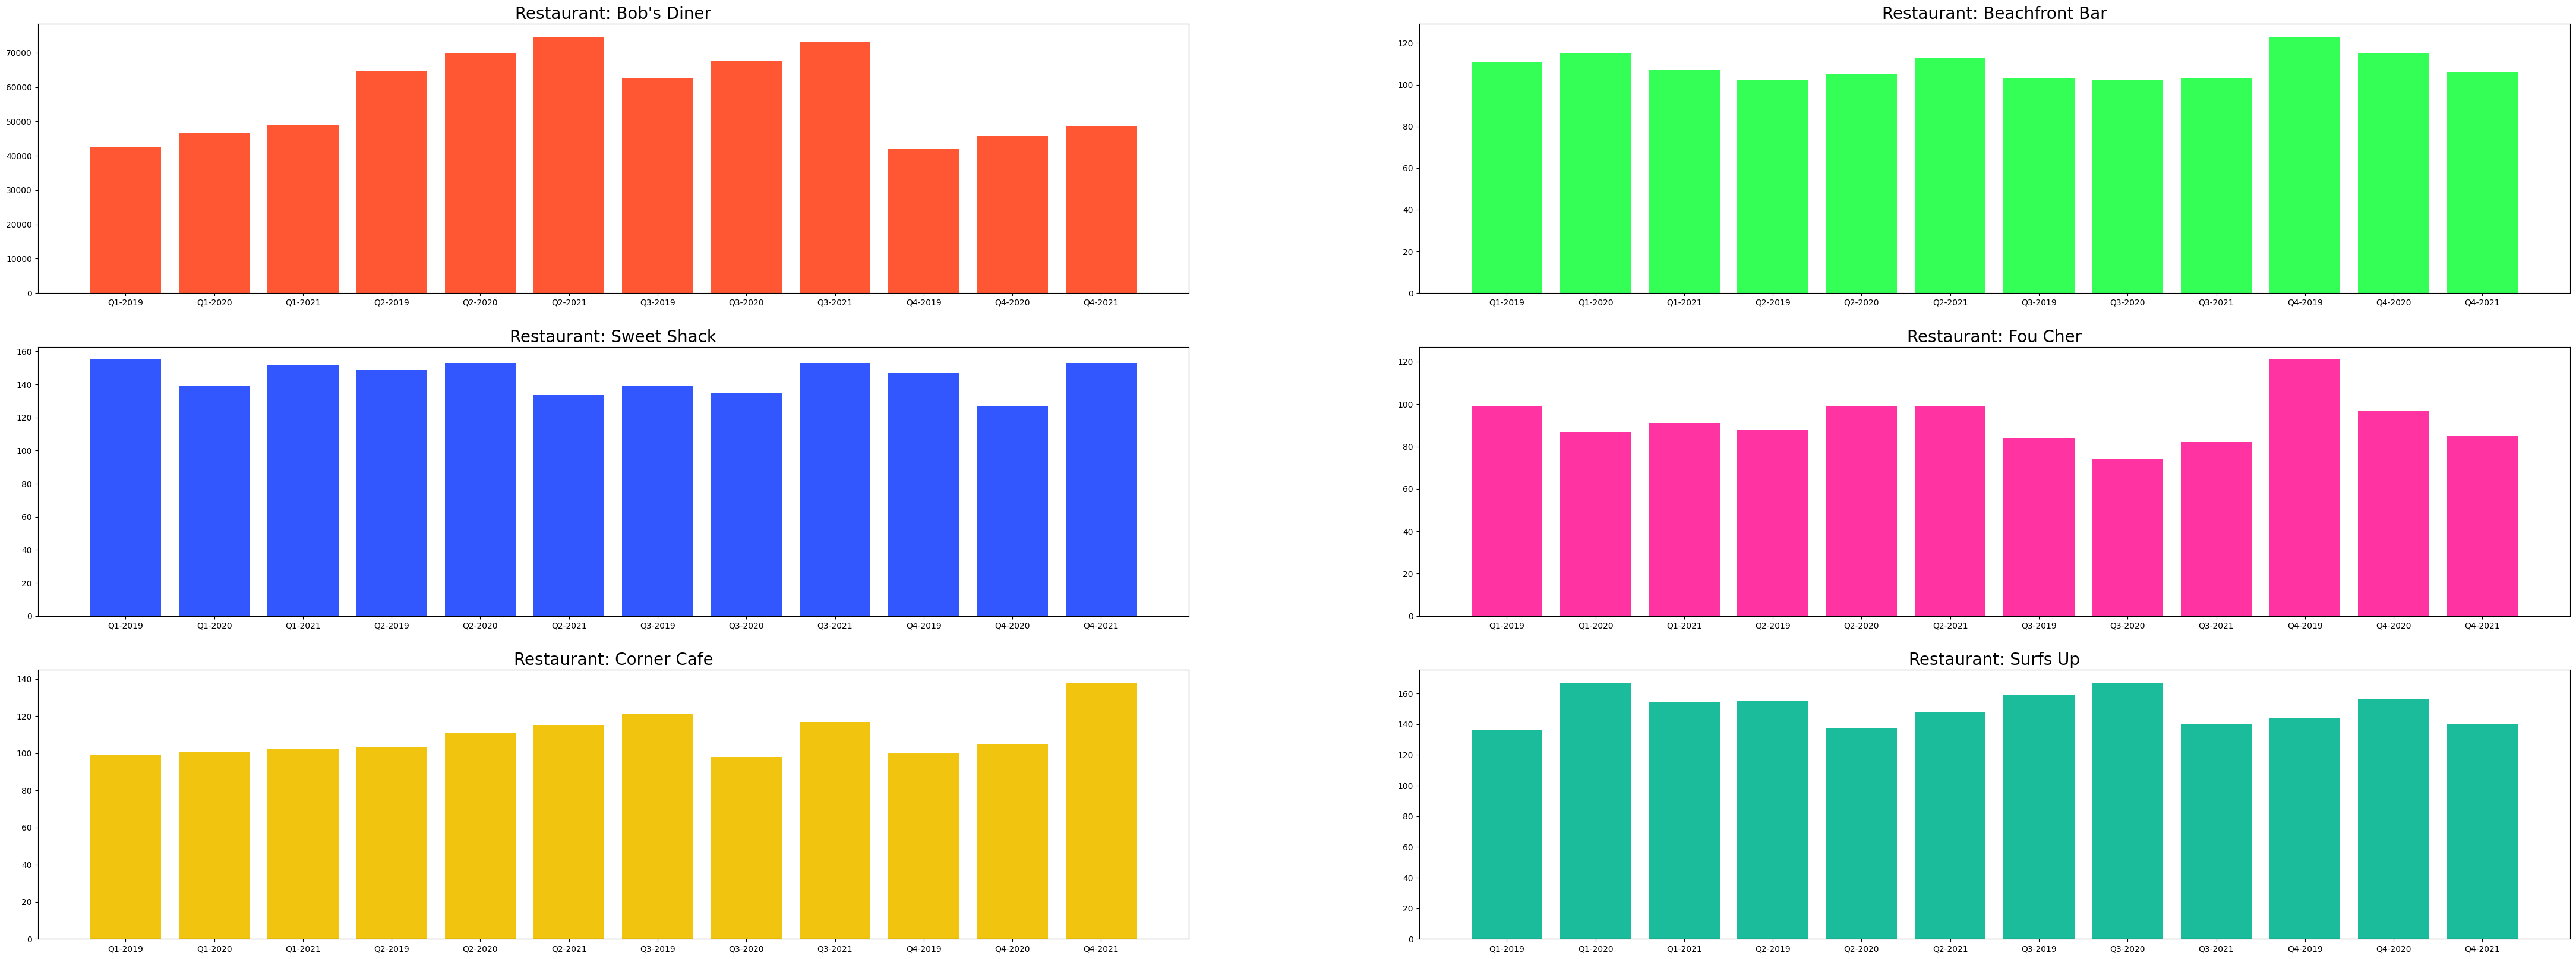

In [93]:
# Plotting up the bar graphs of each restaurant with thier year wise sales

plot_data = data.pivot_table(values='item_count', index='quart-year', columns='store_id', aggfunc='sum')
fig, axes = plt.subplots(3, 2, figsize=(55, 20))

# Define a new color palette (replace these colors with your preferred ones)
custom_colors = ['#FF5733', '#33FF57', '#3357FF', '#FF33A1', '#F1C40F', '#1ABC9C']

for idx, (store_id, ax) in enumerate(zip(range(1, 7), axes.flatten())):
    ax.bar(plot_data.index, plot_data[store_id], color=custom_colors[idx])  # Use custom colors
    restaurant_name = restaurants.loc[restaurants['id'] == store_id, 'name'].values[0]
    ax.set_title(f'Restaurant: {restaurant_name}', fontsize=20)

In [95]:
# Also making up the pivot table of the sales of the restuarant to show up the year wise sales of each restaurant

plot_data = data.groupby(['quart-year', 'store_id'])['item_count'].sum().unstack(level='store_id')
plot_data

store_id,1,2,3,4,5,6
quart-year,,,,,,
Q1-2019,42631.0,111.0,155.0,99.0,99.0,136.0
Q1-2020,46669.0,115.0,139.0,87.0,101.0,167.0
Q1-2021,48888.0,107.0,152.0,91.0,102.0,154.0
Q2-2019,64662.0,102.0,149.0,88.0,103.0,155.0
Q2-2020,70049.0,105.0,153.0,99.0,111.0,137.0
Q2-2021,74678.0,113.0,134.0,99.0,115.0,148.0
Q3-2019,62546.0,103.0,139.0,84.0,121.0,159.0
Q3-2020,67665.0,102.0,135.0,74.0,98.0,167.0
Q3-2021,73299.0,103.0,153.0,82.0,117.0,140.0


### Month vise sales of each Restaurant

C:\Users\NEC\AppData\Local\Temp\ipykernel_10340\2264990508.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels=months, fontsize=20)
C:\Users\NEC\AppData\Local\Temp\ipykernel_10340\2264990508.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels=months, fontsize=20)
C:\Users\NEC\AppData\Local\Temp\ipykernel_10340\2264990508.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels=months, fontsize=20)
C:\Users\NEC\AppData\Local\Temp\ipykernel_10340\2264990508.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels=months, fontsize=20)
C:\Users\NEC\AppData\Local\T

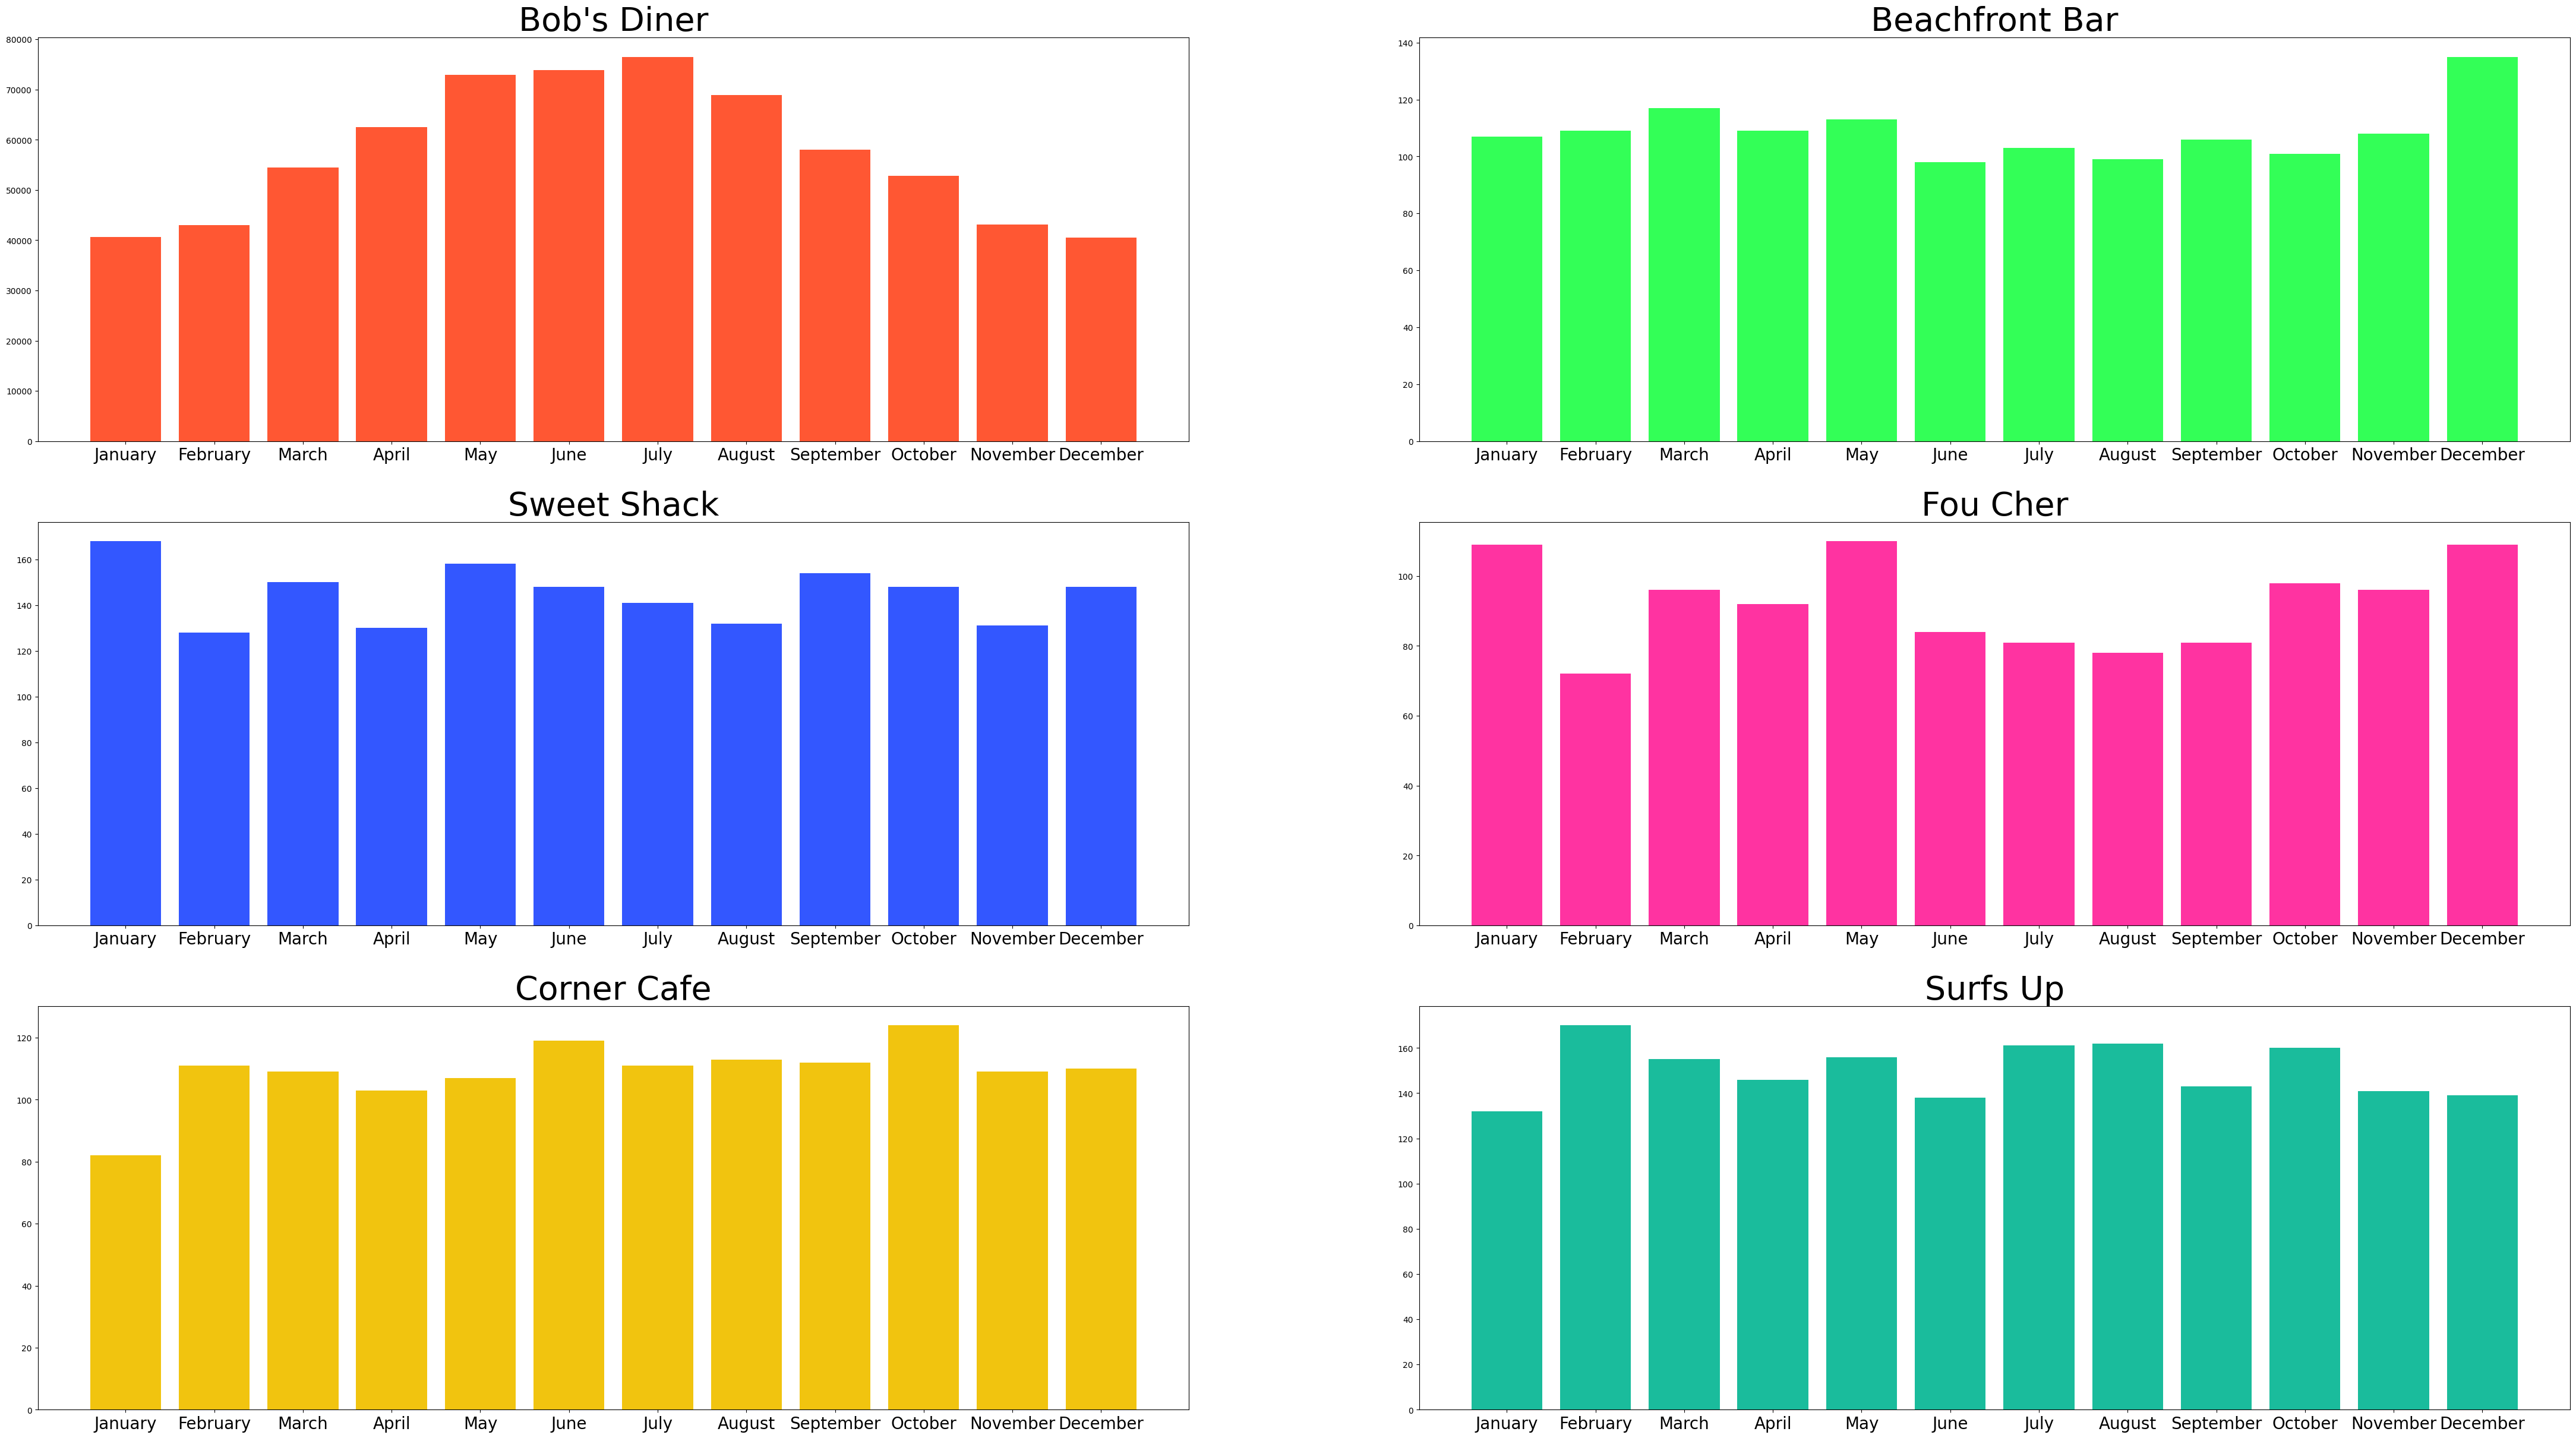

In [99]:
# visualizing the bar graphs of each of the reataurant sales per month

plot_data = data.groupby(['month_name', 'store_id'])['item_count'].sum().unstack(level='store_id')
plot_data = plot_data.reindex(months)
fig, axes = plt.subplots(3, 2, figsize=(55, 30))

custom_colors = ['#FF5733', '#33FF57', '#3357FF', '#FF33A1', '#F1C40F', '#1ABC9C']

for idx, (store_id, ax) in enumerate(zip(range(1, 7), axes.flatten())):
    ax.bar(plot_data.index, plot_data[store_id], color=custom_colors[idx]) 
    restaurant_name = restaurants.loc[restaurants['id'] == store_id, 'name'].values[0]
    ax.set_title(f'{restaurant_name}', fontsize=40)
    ax.set_xticklabels(labels=months, fontsize=20)

### Day wise Sales of each Restaurant

C:\Users\NEC\AppData\Local\Temp\ipykernel_10340\3472861653.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels=day_names, fontsize=20)
C:\Users\NEC\AppData\Local\Temp\ipykernel_10340\3472861653.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels=day_names, fontsize=20)
C:\Users\NEC\AppData\Local\Temp\ipykernel_10340\3472861653.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels=day_names, fontsize=20)
C:\Users\NEC\AppData\Local\Temp\ipykernel_10340\3472861653.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels=day_names, fontsize=20)
C:\Users\NEC\App

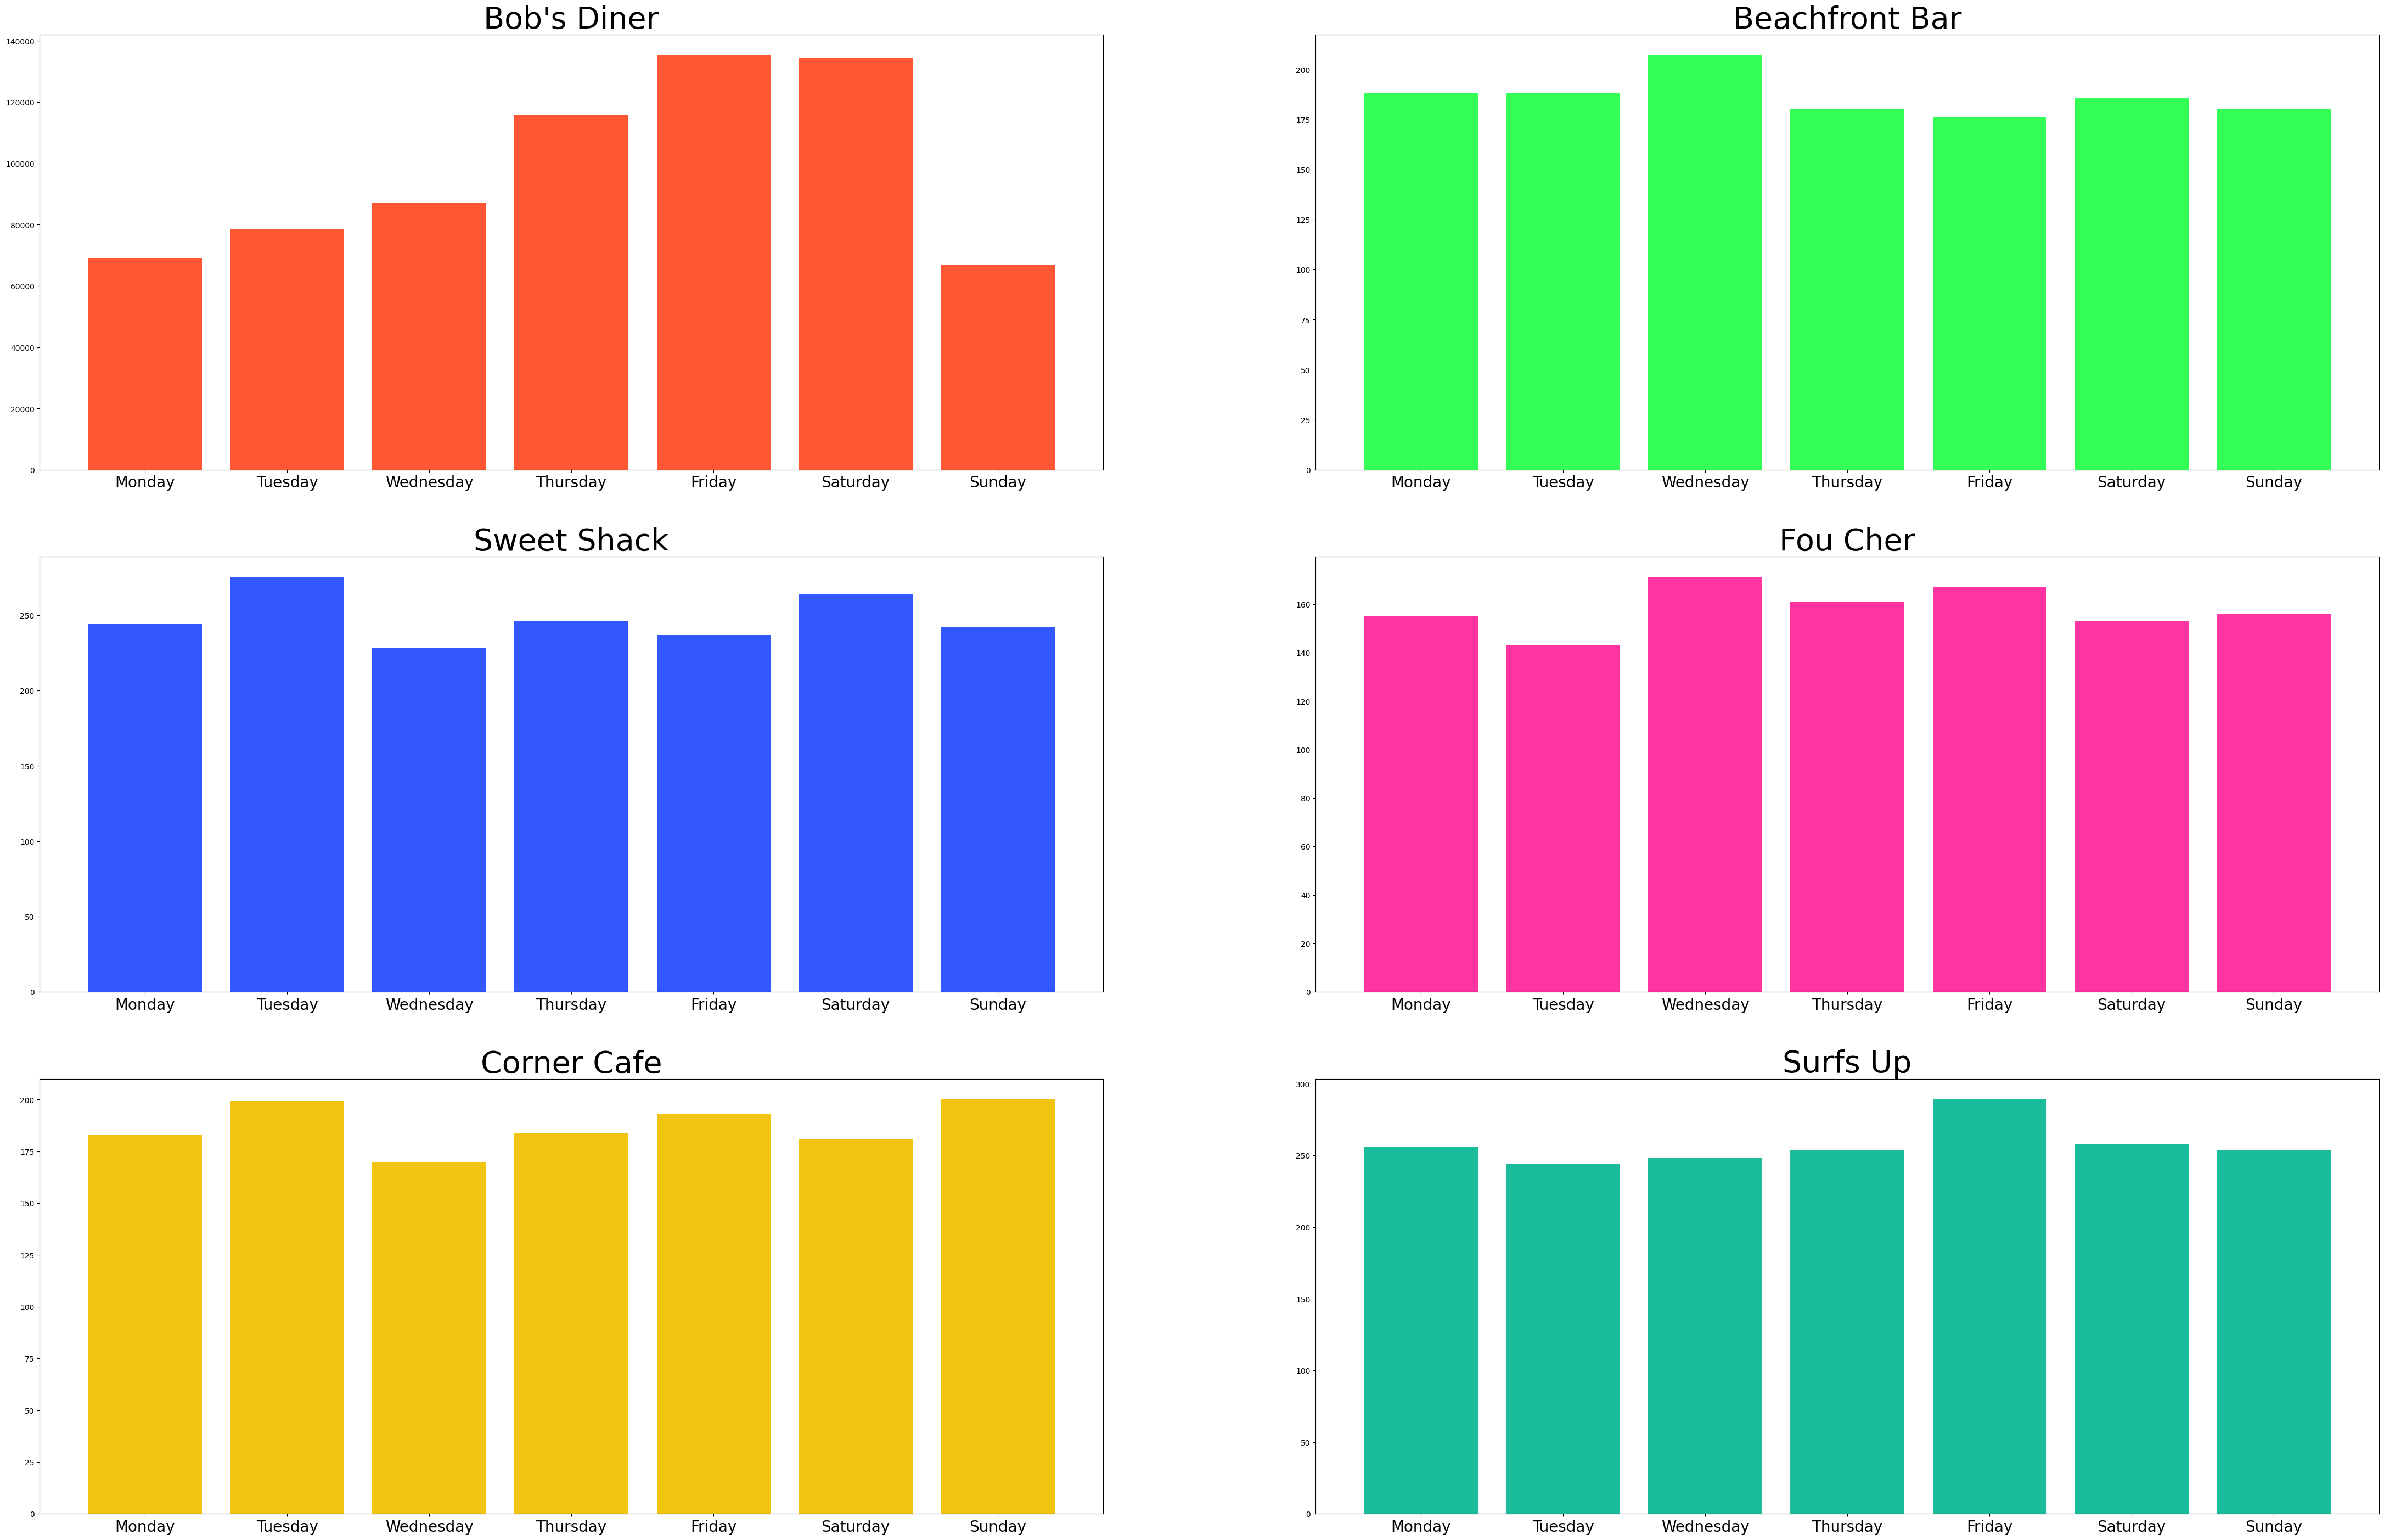

In [102]:
# displaying bar graph to show up day vise sales of the restaurants

plot_data = data.groupby(['weekday', 'store_id'])['item_count'].sum().unstack(level='store_id')
plot_data = plot_data.reindex(day_names)
fig, axes = plt.subplots(3, 2, figsize=(55, 35))

custom_colors = ['#FF5733', '#33FF57', '#3357FF', '#FF33A1', '#F1C40F', '#1ABC9C']

for idx, (store_id, ax) in enumerate(zip(range(1, 7), axes.flatten())):
    ax.bar(plot_data.index, plot_data[store_id], color=custom_colors[idx])  
    restaurant_name = restaurants.loc[restaurants['id'] == store_id, 'name'].values[0]
    ax.set_title(f'{restaurant_name}', fontsize=40)
    ax.set_xticklabels(labels=day_names, fontsize=20)

plt.show()

## f.  Identifying the most popular items overall and the stores where they are being sold. Also, finding out the most popular item at each store

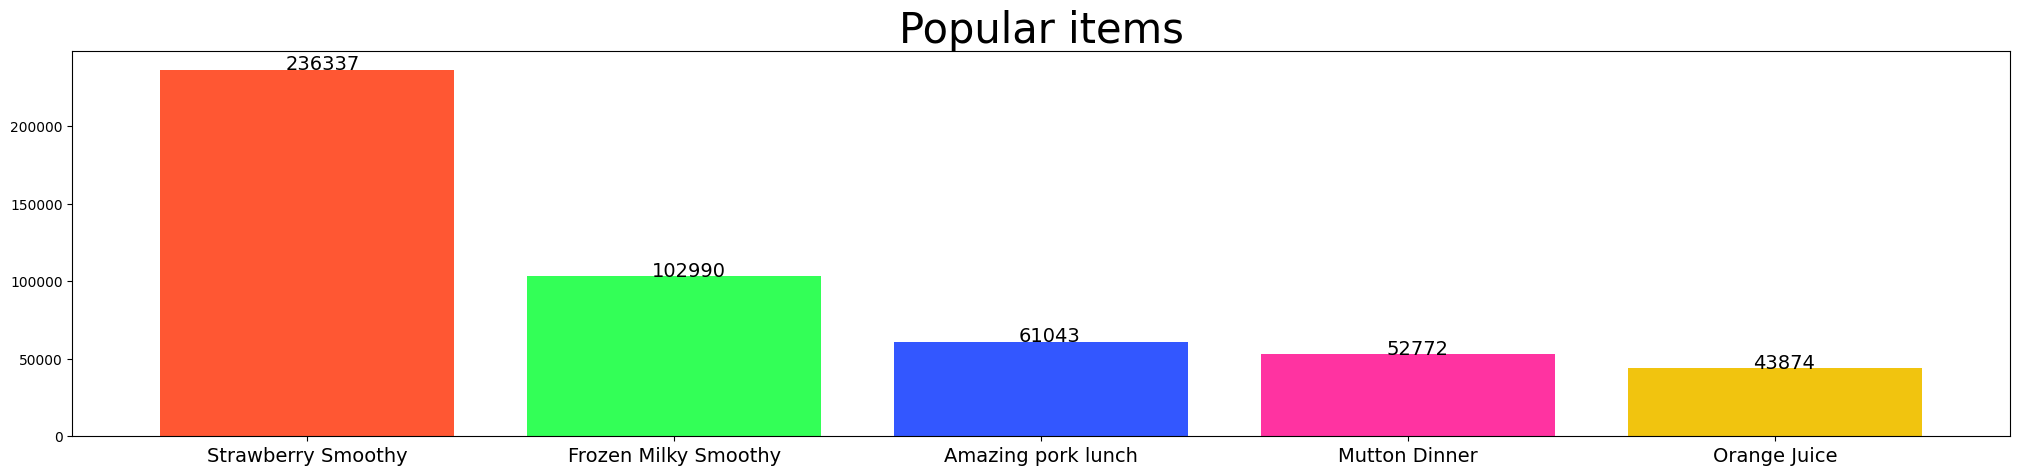

In [107]:
# Displaying bar-garph to show the infamous item across the restaurants

plot_data = data.groupby('item_id')['item_count'].sum().nlargest(5).reset_index()
final_plot_data = plot_data.merge(items[['id', 'name', 'kcal', 'cost', 'store_id']], left_on='item_id', right_on='id', how='left')[['item_id', 'item_count', 'name', 'kcal', 'cost', 'store_id']]

custom_colors = ['#FF5733', '#33FF57', '#3357FF', '#FF33A1', '#F1C40F']

plt.figure(figsize=(25, 5))
plt.bar(final_plot_data['name'], final_plot_data['item_count'], color=custom_colors)

plt.title('Popular items', fontsize=30)

for idx, val in enumerate(final_plot_data['item_count']):
    plt.annotate(f'{val:.0f}', xy=(idx - 0.06, val), fontsize=14)

plt.xticks(fontsize=14)
plt.show()

### Popular Items Restaurant vise

In [114]:
# Creating a pivot table with 'item_id' as rows, 'store_id' as columns, and 'item_count' as values as well as filling missing values with 0
count_data = data.pivot_table(index = 'item_id', columns = 'store_id',values = 'item_count', aggfunc = 'sum', fill_value = 0 )
# Geting the most popular item in each store by finding the item with the max count
item_ids = count_data.index[count_data.values.argmax(axis = 0)]

In [129]:
# Printing a table in dataframe format to show the most popular items restaurnt vise

# Filtering items to include only the most popular items based on item_ids
pop_items = items.loc[items.id.isin(item_ids), ['store_id', 'id', 'name', 'kcal', 'cost']]

# Merging filtered items with restaurant data to get restaurant names
pop_data = pd.merge(pop_items, restaurants, how='left', left_on='store_id', right_on='id', suffixes=('_item', '_restaurant'))
# Adding the total count of each item from count_data
pop_data['count'] = count_data.loc[item_ids,].sum(axis=0).reset_index().iloc[:,1]

# Selecting relevant columns for final DataFrame
pop_data = pop_data[['name_restaurant', 'name_item', 'kcal', 'cost', 'count']]
pop_data

,name_restaurant,name_item,kcal,cost,count
0,Bob's Diner,Strawberry Smoothy,145,2.89,236337.0
1,Beachfront Bar,Fantastic Milky Smoothy,318,2.91,1147.0
2,Sweet Shack,Awesome Smoothy,78,1.39,1692.0
3,Corner Cafe,Frozen Milky Smoothy,211,3.98,298.0
4,Fou Cher,Blue Ribbon Fruity Vegi Lunch,881,53.98,273.0
5,Surfs Up,Awesome Soft Drink,248,3.06,997.0


## g. Determining if the store with the highest sales volume is also making the most money per day

In [132]:
# finding out the restaurant with most sales

data.groupby('store_id')[['item_count']].sum().reset_index()

,store_id,item_count
0,1,687527.0
1,2,1305.0
2,3,1736.0
3,4,1106.0
4,5,1310.0
5,6,1803.0


In [139]:
# creating sales_amnt column by multiplying item_sold by thier prices
data['sales_amnt'] = data.item_count * data.price

In [147]:
# creating pivot table to show the restraurant with most sales
data.pivot_table(index = 'restaurant_name', columns = 'year', values = 'sales_amnt', aggfunc = 'sum')

year,2019,2020,2021
restaurant_name,,,
Beachfront Bar,1281.85,1267.21,1247.14
Bob's Diner,1849483.49,2112331.91,2375460.29
Corner Cafe,5292.93,5347.71,5910.79
Fou Cher,9698.80,8590.87,9595.70
Surfs Up,5132.65,5314.43,5204.41
Sweet Shack,872.59,828.65,877.03


### Conclusion

**Bob's Diner** has the highest sales volume and also generates the most money per day, with approximately **17,344.1** per day. This means that the store with the highest sales volume is indeed making the most money daily.


## h. Identifying the most expensive item at each restaurant and find out its calorie count

In [639]:
import pandas as pd

# Assuming `data` is your DataFrame
# Group by 'restaurant_name' and find the row with the maximum price for each group
most_expensive_items = data.loc[data.groupby('restaurant_name')['price'].idxmax()]

# Select only the relevant columns (restaurant_name, price, kcal)
result = most_expensive_items[['restaurant_name', 'price', 'kcal']]

# Display the result
result


,restaurant_name,price,kcal
68,Beachfront Bar,5.70,538
0,Bob's Diner,29.22,931
58,Corner Cafe,26.37,653
82,Fou Cher,53.98,881
8,Surfs Up,26.21,607
79,Sweet Shack,7.70,636


C:\Users\NEC\AppData\Local\Temp\ipykernel_10340\2383469437.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


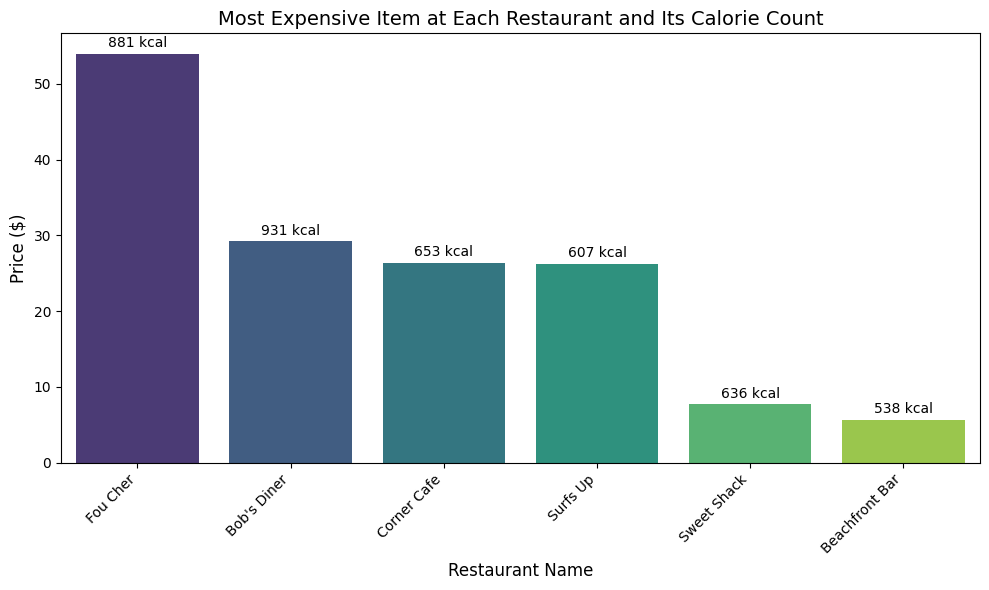

In [649]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming `result` DataFrame contains the columns: 'restaurant_name', 'price', and 'kcal'

# Sort the data by price for better visualization
result_sorted = result.sort_values(by='price', ascending=False)

# Create the bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=result_sorted, 
    x='restaurant_name', 
    y='price', 
    palette='viridis'
)

# Add calorie count as labels directly on top of each bar
for bar, kcal in zip(ax.patches, result_sorted['kcal']):
    bar_height = bar.get_height()  # Get the height of the bar (price value)
    ax.text(
        bar.get_x() + bar.get_width() / 2,  # x-coordinate (center of the bar)
        bar_height + 0.5,  # y-coordinate (slightly above the bar height)
        f"{kcal} kcal",  # Text to display
        ha='center', 
        va='bottom',
        fontsize=10
    )

# Set plot title and labels
plt.title('Most Expensive Item at Each Restaurant and Its Calorie Count', fontsize=14)
plt.xlabel('Restaurant Name', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()

# Forecasting sales using Machine Learning Algorithms

## a. Generating necessary columns for model deployment

In [184]:
data.head(2)

,date,item_id,price,item_count,store_id,item_name,kcal,restaurant_name,weekday,month_name,quarter,year,quart-year,sales_amnt
0,2019-01-01,3,29.22,2.0,1,Sweet Fruity Cake,931,Bob's Diner,Tuesday,January,1,2019,Q1-2019,58.44
1,2019-01-01,4,26.42,22.0,1,Amazing Steak Dinner with Rolls,763,Bob's Diner,Tuesday,January,1,2019,Q1-2019,581.24


In [188]:
# Grouping the data by 'date' and perform aggregation
time_series = data.groupby(['date']).agg({
    # Suming the 'item_count' for each group
    'item_count': 'sum', 
    
    # Getting the unique value for 'weekday' for each group (assuming all values are the same for each date)
    'weekday': lambda x: x.unique()[0],
    
    # Getting the unique value for 'quarter' for each group
    'quarter': lambda x: x.unique()[0],
    
    # Getting the unique value for 'year' for each group
    'year': lambda x: x.unique()[0],
    
    # Getting the unique value for 'month_name' for each group
    'month_name': lambda x: x.unique()[0],
    
    # Redundant 'year' column aggregation (this will overwrite the previous 'year' aggregation)
    'year': lambda x: x.unique()[0]
})

In [190]:
# adding some more features to time_series data

time_series['day_year'] = time_series.index.day_of_year
time_series['day_month'] = time_series.index.day
time_series['week_num'] = time_series.index.isocalendar().week.astype(int)
time_series

,item_count,weekday,quarter,year,month_name,day_year,day_month,week_num
date,,,,,,,,
2019-01-01,427.0,Tuesday,1,2019,January,1,1,1
2019-01-02,337.0,Wednesday,1,2019,January,2,2,1
2019-01-03,445.0,Thursday,1,2019,January,3,3,1
2019-01-04,564.0,Friday,1,2019,January,4,4,1
2019-01-05,552.0,Saturday,1,2019,January,5,5,1
...,...,...,...,...,...,...,...,...
2021-12-27,192.0,Monday,4,2021,December,361,27,52
2021-12-28,344.0,Tuesday,4,2021,December,362,28,52
2021-12-29,371.0,Wednesday,4,2021,December,363,29,52


In [196]:
# converting categorical columns into numeric format to train our model

ord_enc = OrdinalEncoder(categories = [months, day_names])
ord_enc.fit(time_series[['month_name', 'weekday']])
time_series[['month_name', 'weekday']] = ord_enc.transform(time_series[['month_name', 'weekday']])

In [198]:
time_series

,item_count,weekday,quarter,year,month_name,day_year,day_month,week_num
date,,,,,,,,
2019-01-01,427.0,1.0,1,2019,0.0,1,1,1
2019-01-02,337.0,2.0,1,2019,0.0,2,2,1
2019-01-03,445.0,3.0,1,2019,0.0,3,3,1
2019-01-04,564.0,4.0,1,2019,0.0,4,4,1
2019-01-05,552.0,5.0,1,2019,0.0,5,5,1
...,...,...,...,...,...,...,...,...
2021-12-27,192.0,0.0,4,2021,11.0,361,27,52
2021-12-28,344.0,1.0,4,2021,11.0,362,28,52
2021-12-29,371.0,2.0,4,2021,11.0,363,29,52


## Generating Test data

In [201]:
train = time_series[time_series.index < '2021-07-01'] # using all the data before 2021-07-01
test = time_series[time_series.index >= '2021-07-01'] # using last 6 months data for testing 

In [203]:
# Defining the target variable 'y_var' as 'item_count'
y_var = 'item_count'

# Creating a list of feature variables 'x_vars' by dropping 'item_count' column from 'time_series'
x_vars = time_series.drop(columns='item_count').columns

In [205]:
# splitting data into x and y training and testing samples

X_train = train[x_vars]
Y_train = train[y_var]
X_test = test[x_vars]
Y_test = test[y_var]

## Applying Linear Regression Model

In [208]:
lr = LinearRegression()
lr.fit(X_train, Y_train)

LinearRegression()

In [ ]:
test['lr_pred'] = lr.predict(X_test)

C:\Users\NEC\AppData\Local\Temp\ipykernel_10340\3421247276.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['lr_pred'] = lr.predict(X_test)


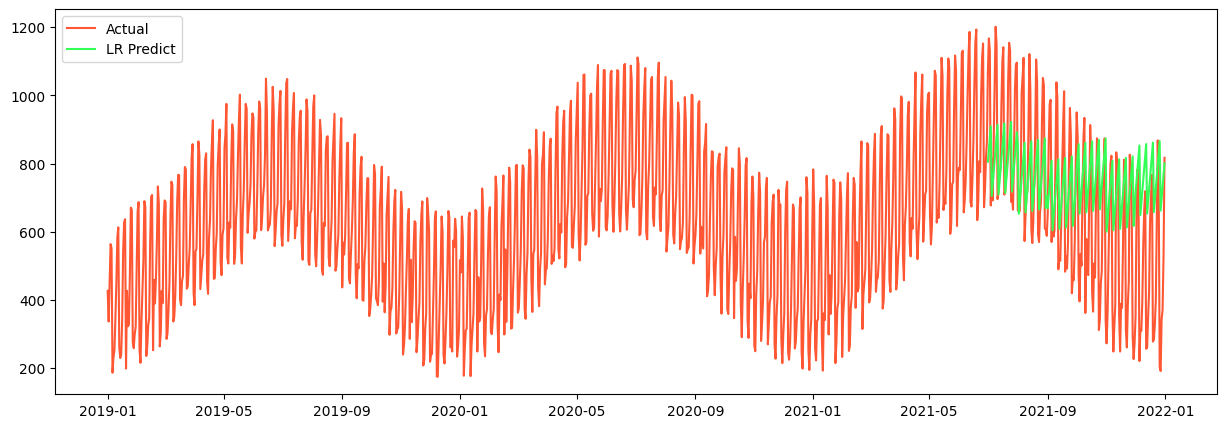

In [212]:
# showing predictions of Linear Regression model

plt.figure(figsize=(15, 5))

# Plotting the actual data with a custom color
plt.plot(time_series['item_count'], label="Actual", color='#FF5733')  # Red color for actual

# Plotting the predicted data with a different custom color
plt.plot(test['lr_pred'], label="LR Predict", color='#33FF57')  # Green color for prediction

# Adding the legend with a custom location
plt.legend(loc='upper left')

# Displaying the plot
plt.show()

In [216]:
# Calculating the metrics
lr_rmse = mean_squared_error(y_true=test['item_count'], y_pred=test['lr_pred'], squared=False)
lr_mae = mean_absolute_error(y_true=test['item_count'], y_pred=test['lr_pred'])
lr_r2_score = r2_score(y_true=test['item_count'], y_pred=test['lr_pred'])


# Creating a DataFrame to display the results
results = pd.DataFrame({
    'Linear Regression': [lr_rmse, lr_mae, lr_r2_score * 100]
}, index=['RMSE', 'MAE', 'R2_Score']).round(2)

# Displaying the results
results

C:\Users\NEC\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


,Linear Regression
RMSE,244.21
MAE,196.04
R2_Score,7.65


## Applying Random Forest Model

In [219]:
rf = RandomForestRegressor(n_estimators=100, max_depth=21)
rf.fit(X_train, Y_train)

RandomForestRegressor(max_depth=21)

In [221]:
test['rf_pred'] = rf.predict(X_test)

C:\Users\NEC\AppData\Local\Temp\ipykernel_10340\582745053.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['rf_pred'] = rf.predict(X_test)


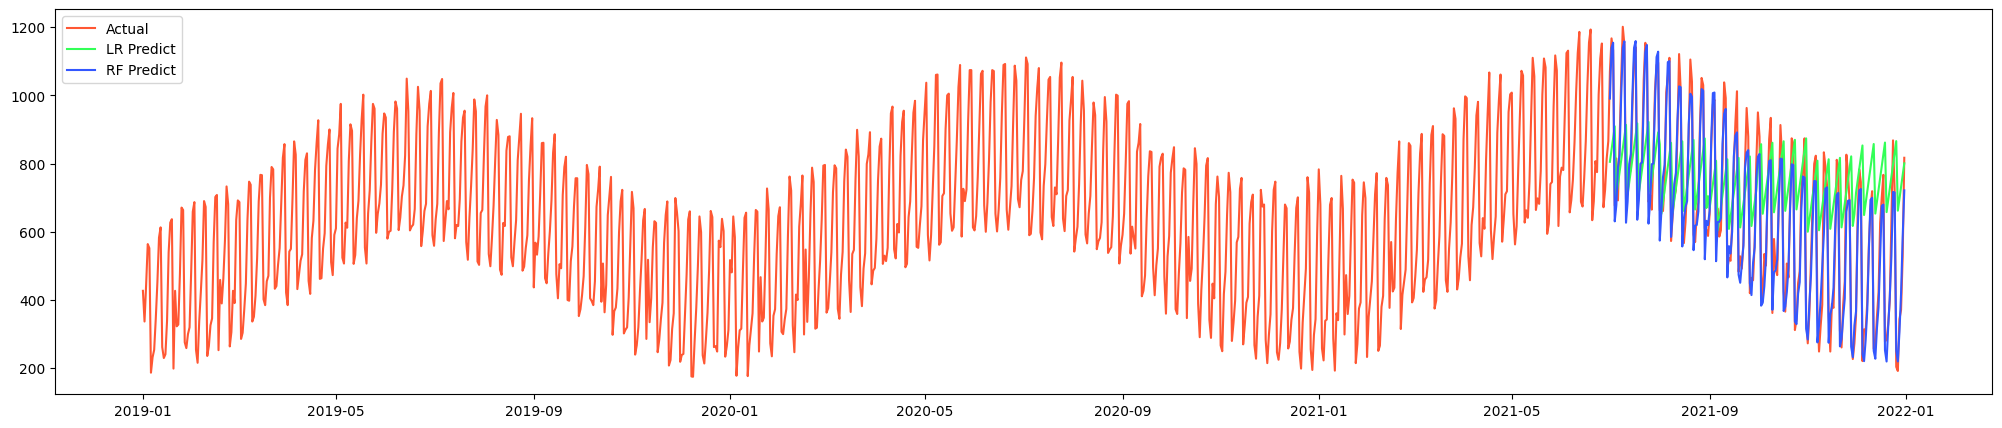

In [223]:
# creating plot to visualize the predictions of Random Forest model as well as Linear regression model for comparison purposes

plt.figure(figsize=(25, 5))

# Plotting the actual data with a custom color
plt.plot(time_series['item_count'], label="Actual", color='#FF5733')  # Red color for actual

# Plotting the linear regression predicted data with a different custom color
plt.plot(test['lr_pred'], label="LR Predict", color='#33FF57')  # Green color for LR prediction

# Plotting the random forest predicted data with another custom color
plt.plot(test['rf_pred'], label="RF Predict", color='#3357FF')  # Blue color for RF prediction

# Adding the legend with a custom location
plt.legend(loc='upper left')

# Displaying the plot
plt.show()

In [225]:
# Calculating the metrics for Random Forest
rf_rmse = mean_squared_error(y_true=test['item_count'], y_pred=test['rf_pred'], squared=False)
rf_mae = mean_absolute_error(y_true=test['item_count'], y_pred=test['rf_pred'])
rf_r2_score = r2_score(y_true=test['item_count'], y_pred=test['rf_pred'])


# Storing the results in the existing DataFrame
results['Random Forest'] = [rf_rmse, rf_mae, rf_r2_score * 100]

# Displaying the results with rounded values
results.round(2)

C:\Users\NEC\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


,Linear Regression,Random Forest
RMSE,244.21,60.09
MAE,196.04,47.77
R2_Score,7.65,94.41


## Applying XGBoost model

In [228]:
# Initializing the XGBoost regressor with specified hyperparameters
xgb = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
# Fitting the model to the training data and evaluate on both train and test sets
xgb.fit(X_train, Y_train,
        eval_set=[(X_train, Y_train), (X_test, Y_test)],
        verbose=100)

[0]	validation_0-rmse:660.07829	validation_1-rmse:709.01212
[100]	validation_0-rmse:262.51190	validation_1-rmse:311.53220


C:\Users\NEC\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:31:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:121.36888	validation_1-rmse:171.11193
[300]	validation_0-rmse:71.72975	validation_1-rmse:105.03640
[400]	validation_0-rmse:52.50055	validation_1-rmse:78.37923
[500]	validation_0-rmse:44.19461	validation_1-rmse:71.59216
[590]	validation_0-rmse:40.38314	validation_1-rmse:71.95490


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

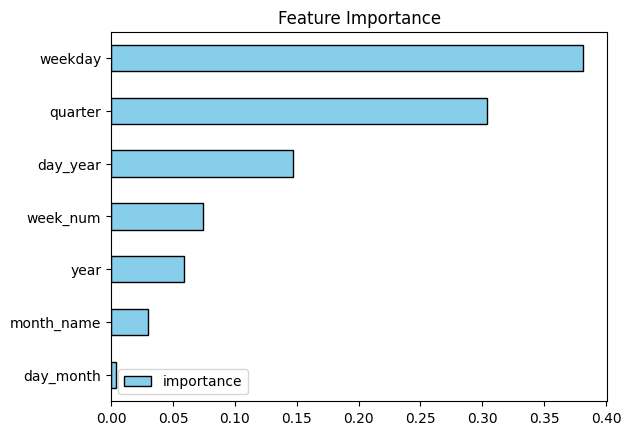

In [230]:
# Creating a DataFrame for feature importances
importance = pd.DataFrame(
    data=xgb.feature_importances_,
    index=xgb.get_booster().feature_names,
    columns=['importance']
)

# Sorting the importance values
importance_sorted = importance.sort_values('importance')

# Plotting the feature importances as a horizontal bar chart with a custom color
importance_sorted.plot(kind='barh', title='Feature Importance', color='skyblue', edgecolor='black')

# Displaying the plot
plt.show()

In [232]:
test['xgb_pred'] = xgb.predict(X_test)

C:\Users\NEC\AppData\Local\Temp\ipykernel_10340\5488039.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['xgb_pred'] = xgb.predict(X_test)


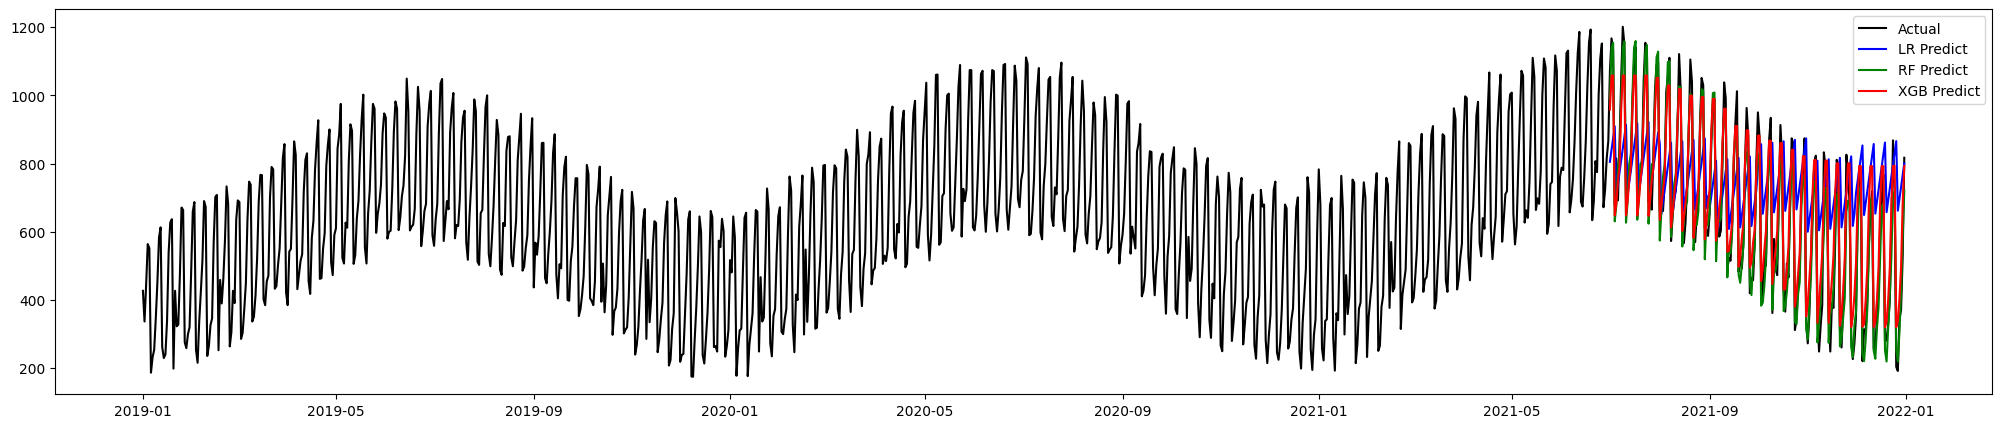

In [234]:
# Creating line plot to show the predictions of all the machine learning model Linear Regression, Random Forest and XGBoost 
plt.figure(figsize=(25, 5))

# Plotting each prediction with custom colors for distinction
plt.plot(time_series['item_count'], label="Actual", color='black')
plt.plot(test['lr_pred'], label="LR Predict", color='blue')
plt.plot(test['rf_pred'], label="RF Predict", color='green')
plt.plot(test['xgb_pred'], label="XGB Predict", color='red')

# Adding the legend to the plot
plt.legend()

# Displaying the plot
plt.show()

In [246]:
# Calculating evaluation metrics for XGBoost predictions
xgb_rmse = mean_squared_error(test['item_count'], test['xgb_pred'], squared=False)
xgb_mae = mean_absolute_error(test['item_count'], test['xgb_pred'])
xgb_r2_score = r2_score(test['item_count'], test['xgb_pred'])

# Updating the results DataFrame with XGBoost metrics
results['XGBoost'] = [xgb_rmse, xgb_mae, xgb_r2_score * 100]

# Rounding the results for better presentation
results = results.round(2)
results

C:\Users\NEC\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


,Linear Regression,Random Forest,XGBoost
RMSE,244.21,60.09,71.18
MAE,196.04,47.77,58.45
R2_Score,7.65,94.41,92.15


## Model Performance Comparison

Here’s a brief comparison of the performance of the three models:

### 1. **Linear Regression**:
- **RMSE**: 244.21 (higher, indicating a larger error)
- **MAE**: 196.04 (also relatively high, suggesting the model's predictions have a significant average deviation)
- **R² Score**: 7.65 (very low, indicating poor fit and minimal explanatory power)

### 2. **Random Forest**:
- **RMSE**: 60.09 (much lower, indicating better predictive accuracy)
- **MAE**: 47.77 (much lower than Linear Regression, showing more precise predictions)
- **R² Score**: 94.41 (very high, indicating a very good fit to the data and strong predictive power)

### 3. **XGBoost**:
- **RMSE**: 71.18 (slightly higher than Random Forest, but still a good performance)
- **MAE**: 58.45 (slightly higher than Random Forest, but still a good improvement over Linear Regression)
- **R² Score**: 92.15 (slightly lower than Random Forest, but still a strong model with good fit)

---

## Summary:
- **Random Forest** outperforms both **Linear Regression** and **XGBoost** in all metrics (lower RMSE, lower MAE, and higher R² score).
- **XGBoost** also shows strong performance but is slightly less accurate than **Random Forest**.
- **Linear Regression** shows the weakest performance with much higher RMSE and MAE, and a very low R² score, indicating that it is not well-suited for this dataset.

**Random Forest** seems to be the best choice among the three models based on these results.


## Making Future Prediction using Random Forest

In [250]:
time_series.index.max()

Timestamp('2021-12-31 00:00:00')

In [252]:
# Creating a DataFrame with dates from January 1, 2022 to December 31, 2022
future_predictors = pd.DataFrame(pd.date_range(start="2022-01-01", end="2022-12-31"), columns=['date'])

# Setting the 'date' column as the index and convert it to datetime format
future_predictors.index = pd.to_datetime(future_predictors.date)

In [256]:
# Extracting the ISO week number from the 'date' column in the future_predictors DataFrame
future_predictors.date.dt.isocalendar().week

date
2022-01-01    52
2022-01-02    52
2022-01-03     1
2022-01-04     1
2022-01-05     1
              ..
2022-12-27    52
2022-12-28    52
2022-12-29    52
2022-12-30    52
2022-12-31    52
Name: week, Length: 365, dtype: UInt32

In [260]:
# Adding new date-related columns to the future_predictors DataFrame

# Extracting the name of the weekday (e.g., Monday, Tuesday, etc.)
future_predictors['weekday'] = future_predictors.date.dt.day_name()

# Getting the quarter of the year (1 to 4)
future_predictors['quarter'] = future_predictors.date.dt.quarter

# Getting the year from the date
future_predictors['year'] = future_predictors.date.dt.year

# Extracting the full name of the month (e.g., January, February, etc.)
future_predictors['month_name'] = future_predictors.date.dt.month_name()

# Extracting the day of the year (1 to 365/366)
future_predictors['day_year'] = future_predictors.date.dt.day_of_year

# Extracting the day of the month (1 to 31)
future_predictors['day_month'] = future_predictors.date.dt.day

# Extracting the ISO week number
future_predictors['week_num'] = future_predictors.date.dt.isocalendar().week

In [262]:
# Transforming 'month_name' and 'weekday' columns using ordinal encoding
future_predictors[['month_name', 'weekday']] = ord_enc.transform(future_predictors[['month_name', 'weekday']])

In [264]:
# Using the trained random forest model to make predictions for the future predictors
future_predictors['predictions'] = rf.predict(future_predictors[X_train.columns])

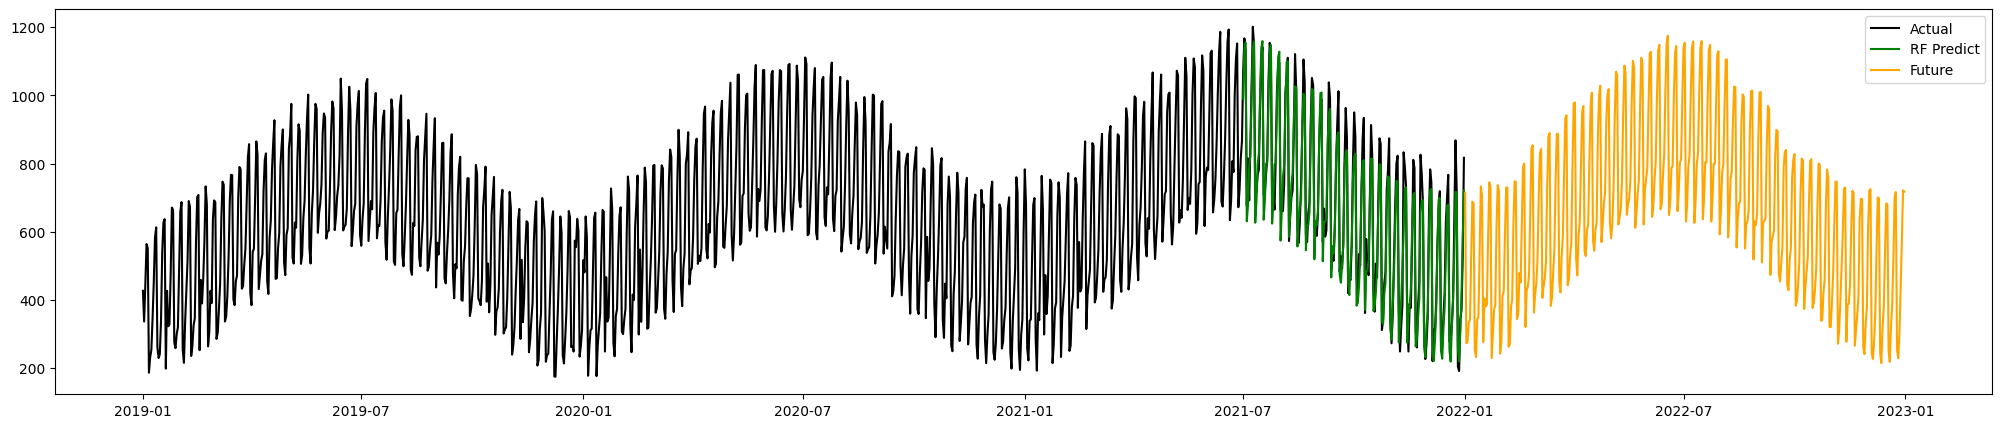

In [266]:
# Visualizing the Graph to show Future predictions
plt.figure(figsize=(25, 5))

# Plotting each prediction with custom colors for distinction
plt.plot(time_series['item_count'], label="Actual", color='black')
plt.plot(test['rf_pred'], label="RF Predict", color='green')
plt.plot(future_predictors['predictions'], label="Future", color='orange')

# Adding the legend to the plot
plt.legend()

# Displaying the plot
plt.show()

# Forecasting sales using Deep Learning

## Generating tiem series data

In [534]:
# this time using sales amount for prediction instead of item_count
time_ser = data.groupby('date').agg({'sales_amnt': 'sum'})
time_ser

,sales_amnt
date,
2019-01-01,4023.00
2019-01-02,3074.69
2019-01-03,4062.71
2019-01-04,5006.81
2019-01-05,4927.53
...,...
2021-12-27,1867.71
2021-12-28,3426.50
2021-12-29,3715.39


In [536]:
train = time_ser[time_ser.index < '2021-07-01'] # using all the data before 2021-07-01
test = time_ser[time_ser.index >= '2021-07-01'] # using last 6 months data for testing 

### Scaling the Data

In [539]:
# Applying MinMax Scaling to scale the data

scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

### Generating data

In [542]:
length = 12
n_features = 1

In [544]:
# Creating a TimeSeriesGenerator object for generating batches of sequential data for time series prediction
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

## Building LSTM Model

In [594]:
# Defining and compiling an LSTM model for time series forecasting

model = Sequential()  # Initialize a Sequential model
# Adding an LSTM layer with 100 units, ReLU activation, and input shape specified by 'length' and 'n_features'
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))

# Adding a Dense layer with 1 unit as the output layer (for regression task)
model.add(Dense(1))
# Compiling the model with Adam optimizer and Mean Squared Error (MSE) as the loss function
model.compile(optimizer='adam', loss='mse')

C:\Users\NEC\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [596]:
# applying EarlyStopping with patience 4
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [598]:
# Creating a TimeseriesGenerator for the test data for validation purposes

validation_generator = TimeseriesGenerator(scaled_test, scaled_test, length=length, batch_size=1)

In [600]:
# Training the LSTM model with the training generator and validating it using the validation generator
# The training process will stop early if no improvement is observed (early stopping callback).

model.fit(generator, epochs=20, 
                    validation_data=validation_generator,
                    callbacks=[early_stop])

Epoch 1/20
887/900 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0443

C:\Users\NEC\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


900/900 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0442 - val_loss: 0.0343
Epoch 2/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0156 - val_loss: 0.0122
Epoch 3/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0099 - val_loss: 0.0168
Epoch 4/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0095 - val_loss: 0.0067
Epoch 5/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0064 - val_loss: 0.0049
Epoch 6/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0053 - val_loss: 0.0070
Epoch 7/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0040 - val_loss: 0.0049


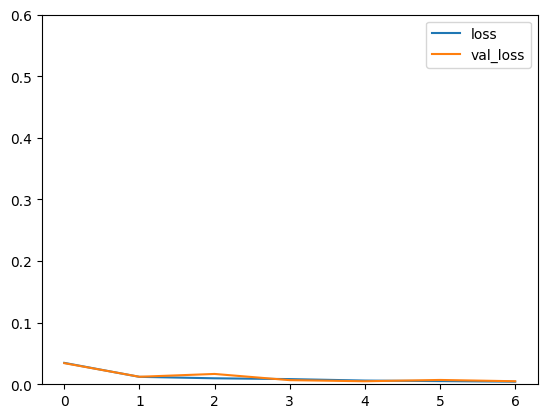

In [602]:
# Creating a DataFrame from the model's training history (loss values) and plotting it to visualize the loss over epochs

losses = pd.DataFrame(model.history.history)  # Converted the training history into a DataFrame
losses.plot()  # Ploting the loss values to visualize the model's learning progress over epochs

plt.ylim(0, 0.6)  
plt.show() 

### Evaluating LSTM model

In [605]:
test_predictions = []

# Creating initial batch using the last 'length' data points from scaled_train
initial_batch = scaled_train[-length:]
current_batch = initial_batch.reshape((1, length, n_features))

# Iterating over the test set to generate predictions
for i in range(len(test)):
    # Generating a prediction using the current batch
    current_prediction = model.predict(current_batch)[0]
    
    # Appending the prediction to the results list
    test_predictions.append(current_prediction)
    
    # Updating the batch by removing the first value and appending the new prediction
    current_batch = np.concatenate([current_batch[:, 1:, :], [[current_prediction]]], axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━

### Making Predictions

In [608]:
# Inversing the scaling transformation on the predicted data to return the values to their original scale

true_predictions = scaler.inverse_transform(test_predictions)  

In [610]:
test['Predictions'] = true_predictions

C:\Users\NEC\AppData\Local\Temp\ipykernel_10340\4269337381.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


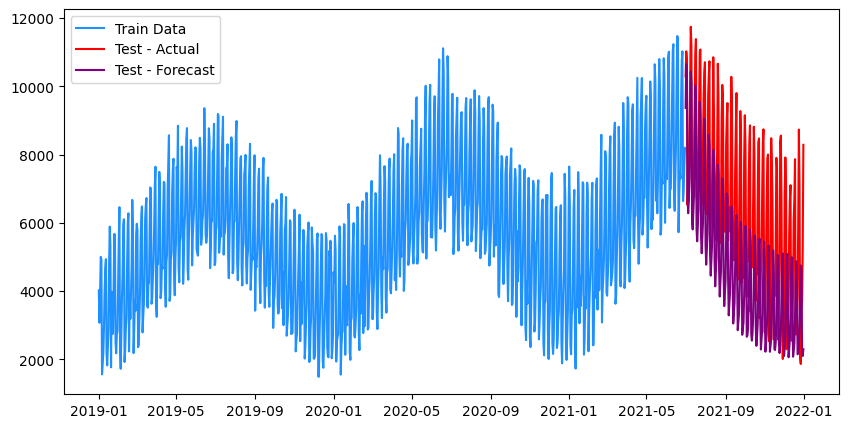

In [612]:
# Creating plot to show the Actual and Forecasted results
plt.figure(figsize = (10,5))

# Plotting the training data in blue
plt.plot(train, color = 'dodgerblue', label = 'Train Data')

# Plotting the actual test data in red
plt.plot(test.sales_amnt, color = 'red', label = 'Test - Actual')

# Plotting the forecasted test data in dark green
plt.plot(test.index, test.Predictions, color = 'purple', label = 'Test - Forecast')

plt.legend()

plt.show()

## c. Calculating MAPE

In [614]:
# Calculating the Mean Absolute Percentage Error (MAPE) to evaluate the performance of the LSTM model

mape_dl = mean_absolute_percentage_error(y_true = test.sales_amnt, y_pred = test.Predictions)
print("MAPE for LSTM : ", mape_dl)  

MAPE for LSTM :  0.3786476629794549


## d. Developing another model using entire training, to forecast next 3 months

In [617]:
# scaling data 
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(time_ser)

In [619]:
time_ser

,sales_amnt
date,
2019-01-01,4023.00
2019-01-02,3074.69
2019-01-03,4062.71
2019-01-04,5006.81
2019-01-05,4927.53
...,...
2021-12-27,1867.71
2021-12-28,3426.50
2021-12-29,3715.39


In [621]:
# Defining the length of the output sequences (in number of timesteps)
length = 3 * 30  # 3 months worth of data (assuming 30 days in a month)

# Create a TimeseriesGenerator to generate the sequences
generator = TimeseriesGenerator(
    data=scaled_full_data, 
    targets=scaled_full_data, 
    length=length, 
    batch_size=1
)

In [623]:
# Define the model
model = Sequential()

# Add LSTM layer
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))

# Add Dense layer for output
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Fit the model
model.fit(generator, epochs=9)

Epoch 1/9


C:\Users\NEC\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\NEC\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1006/1006 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - loss: 0.0467
Epoch 2/9
1006/1006 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - loss: 0.0337
Epoch 3/9
1006/1006 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - loss: 0.0213
Epoch 4/9
1006/1006 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - loss: 0.0083
Epoch 5/9
1006/1006 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - loss: 0.0057
Epoch 6/9
1006/1006 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - loss: 0.0050
Epoch 7/9
1006/1006 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - loss: 0.0044
Epoch 8/9
1006/1006 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - loss: 0.0036
Epoch 9/9
1006/1006 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - loss: 0.0037


<Axes: >

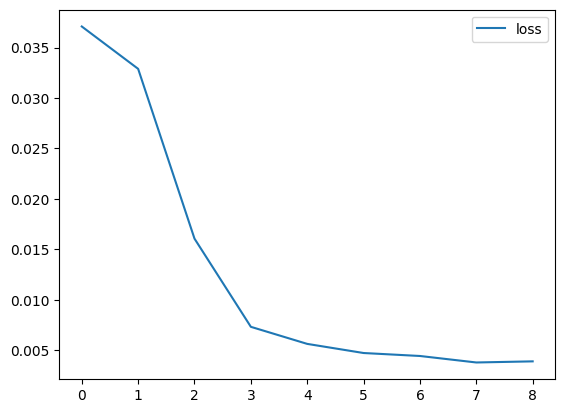

In [627]:
# displaying line plot to show the loss
losses = pd.DataFrame(model.history.history)
losses.plot()

In [629]:
# Initializing an empty list to store predictions
forecast = []
periods = 3 * 30  # Number of periods to forecast

# Getting the last part of the scaled data for the initial batch
first_eval_batch = scaled_full_data[-length:]

# Reshaping the batch to match the LSTM input shape
current_batch = first_eval_batch.reshape((1, length, n_features))

# Looped over the periods to make predictions
for i in range(periods):

    # Making the prediction for the next time step
    current_pred = model.predict(current_batch)[0]

    # Appending the prediction to the list
    forecast.append(current_pred)

    # Updating the batch: remove the first value and add the prediction at the end
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━

In [631]:
# inversed the transformation of scaled data
forecast = scaler.inverse_transform(forecast)

In [633]:
# Creating a range of forecast dates from '2022-01-01' with a frequency of one day for 90 days (3 months)

forecast_dates = pd.date_range(start='2022-01-01 ', periods=3*30, freq="D")

In [635]:
# Creating a DataFrame with forecast data, using forecast_dates as the index and 'Forecast' as the column name

forecast_data = pd.DataFrame(data=forecast, index=forecast_dates,
                             columns=['Forecast']).squeeze()

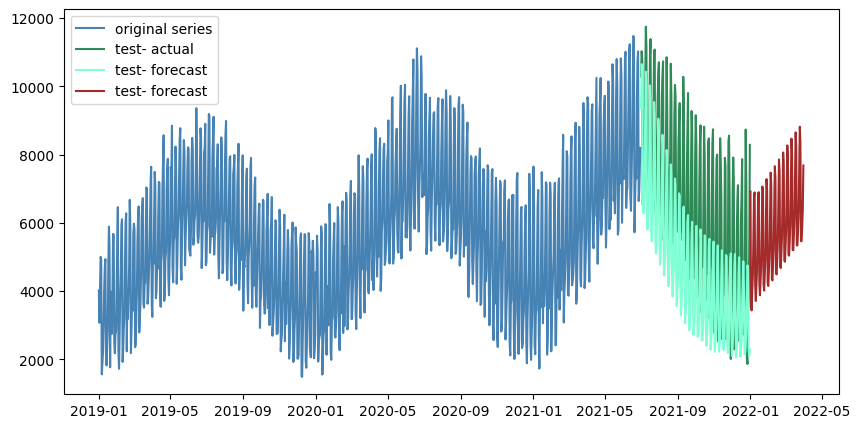

In [637]:
plt.figure(figsize = (10,5))
plt.plot(train.index, train.sales_amnt, color = 'steelblue', label = 'original series') # Plotting the original training data series
plt.plot(test.index, test.sales_amnt,color = 'seagreen', label = 'test- actual') # Plotting the actual test data series
plt.plot(test.index, test.Predictions,color = 'aquamarine', label = 'test- forecast') # Plotting the forecasted test data
plt.plot(forecast_data.index, forecast_data.values, color = 'brown', label = 'test- forecast') # Plotting the future forecasted data
plt.legend()
plt.show()

In [528]:
# showing Mean Average Percentage Error of the LSTM model 
pd.DataFrame([mape_dl ], index = ['LSTM'])

,0
LSTM,0.869753
